<a href="https://colab.research.google.com/github/JECR1970/Capstone/blob/main/1021_SupML_%7BJosep_E_Castellnou%7D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project ML SUPERVISED
## Josep E. Castellnou Ribau
### Jan 2022

#ML CANVAS

#### This is a task to be treated as a ML SUPERVISED (CLASSIFICATION) project.
#### The goal is to generate a ML model that, when applied to the Windows Defender software, produces a warning whenever **a given** machine **['MachineIdentifier']** reaches a certain **probablility** of being affected by malware **['HasDetections']**.


#ANALYSIS

## Import Libraries

In [3599]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

plt.style.use('ggplot')

## Import Data

In [3600]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JFK/Projecte obligatori/sample_mmp.csv', index_col=0)

In [3601]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24202 entries, 8427007 to 352132
Data columns (total 83 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   MachineIdentifier                                  24202 non-null  object 
 1   ProductName                                        24202 non-null  object 
 2   EngineVersion                                      24202 non-null  object 
 3   AppVersion                                         24202 non-null  object 
 4   AvSigVersion                                       24202 non-null  object 
 5   IsBeta                                             24202 non-null  int64  
 6   RtpStateBitfield                                   24113 non-null  float64
 7   IsSxsPassiveMode                                   24202 non-null  int64  
 8   DefaultBrowsersIdentifier                          1098 non-null   float64
 9  

In [3602]:
df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
8427007,f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,8,85219.0,NaN,205.0,172,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,1443.0,275891.0,4.0,5.0,...,HDD,952838.0,0.0,8192.0,AllinOne,23.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134.0,165.0,Professional,PROFESSIONAL,UUPUpgrade,27.0,120.0,FullAuto,0.0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,19951.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,11.0,1.0
8829090,fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,129,54198.0,NaN,126.0,124,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2102.0,248850.0,4.0,5.0,...,HDD,457600.0,0.0,8192.0,Notebook,13.2,1280.0,720.0,Mobile,lion,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134.0,165.0,Professional,PROFESSIONAL,UUPUpgrade,18.0,72.0,FullAuto,0.0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,486.0,48753.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
2731904,4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,0,7.0,0,NaN,46781.0,2.0,1.0,1,149,122689.0,27.0,181.0,56,windows10,x64,10.0.0.0,10586,768,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,1.0,0,NaN,0.0,74.0,RequireAdmin,1.0,1.0,Convertible,Windows.Desktop,2206.0,238234.0,4.0,5.0,...,SSD,221251.0,0.0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,lion,0.000000e+00,10.0.10586.1176,amd64,th2_release_sec,10586.0,1176.0,Core,CORE,Update,24.0,109.0,Notify,0.0,IS_GENUINE,Retail,NaN,0.0,Retail,0.0,554.0,33111.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,15.0,0.0
1359513,270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,164,114587.0,27.0,205.0,172,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,525.0,265410.0,8.0,5.0,...,SSD,228321.0,0.0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,NaN,5.770000e+02,10.0.17134.286,amd64,rs4_release,17134.0,286.0,Core,CORE,IBSClean,27.0,120.0,FullAuto,0.0,

## MLC 2: Data Understanding

#### Index Reset & DataSet size

In [3603]:
#We check that all values in index are unique
df.index.unique()

Int64Index([8427007, 8829090, 2731904, 1359513,  236059, 3771983, 4833329,
             985557,  387390, 7131823,
            ...
            8552746, 4499032, 1490808,  727135, 6205242, 8449833, 8533696,
            1235532, 5943433,  352132],
           dtype='int64', length=24202)

In [3604]:
#and reset the index
df.set_index('MachineIdentifier', inplace=True)

In [3605]:
df.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,8,85219.0,NaN,205.0,172,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,1443.0,275891.0,4.0,5.0,2273.0,...,HDD,952838.0,0.0,8192.0,AllinOne,23.0,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134.0,165.0,Professional,PROFESSIONAL,UUPUpgrade,27.0,120.0,FullAuto,0.0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,355.0,19951.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,11.0,1.0
fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,129,54198.0,NaN,126.0,124,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2102.0,248850.0,4.0,5.0,2660.0,...,HDD,457600.0,0.0,8192.0,Notebook,13.2,1280.0,720.0,Mobile,lion,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134.0,165.0,Professional,PROFESSIONAL,UUPUpgrade,18.0,72.0,FullAuto,0.0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,0.0,486.0,48753.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,0,7.0,0,NaN,46781.0,2.0,1.0,1,149,122689.0,27.0,181.0,56,windows10,x64,10.0.0.0,10586,768,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,1.0,0,NaN,0.0,74.0,RequireAdmin,1.0,1.0,Convertible,Windows.Desktop,2206.0,238234.0,4.0,5.0,2998.0,...,SSD,221251.0,0.0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,lion,0.000000e+00,10.0.10586.1176,amd64,th2_release_sec,10586.0,1176.0,Core,CORE,Update,24.0,109.0,Notify,0.0,IS_GENUINE,Retail,NaN,0.0,Retail,0.0,554.0,33111.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,15.0,0.0
270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,164,114587.0,27.0,205.0,172,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,525.0,265410.0,8.0,5.0,2880.0,...,SSD,228321.0,0.0,8192.0,Notebook,15.5,1920.0,1080.0,Mobil

#### Duplicates and Nulls

In [3606]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24202 entries, f1cd864e97bae82bdf96523e1a539121 to 0a214a81cbf9e459dafcc88098e3e117
Data columns (total 82 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ProductName                                        24202 non-null  object 
 1   EngineVersion                                      24202 non-null  object 
 2   AppVersion                                         24202 non-null  object 
 3   AvSigVersion                                       24202 non-null  object 
 4   IsBeta                                             24202 non-null  int64  
 5   RtpStateBitfield                                   24113 non-null  float64
 6   IsSxsPassiveMode                                   24202 non-null  int64  
 7   DefaultBrowsersIdentifier                          1098 non-null   float64
 8   AVProductStatesIdentifier        

In [3607]:
#Checking for duplicates: there aren't
df.duplicated().value_counts()

False    24202
dtype: int64

In [3608]:
#we check for nulls...
df.isnull().sum()

ProductName                                  0
EngineVersion                                0
AppVersion                                   0
AvSigVersion                                 0
IsBeta                                       0
                                          ... 
Census_IsPenCapable                          1
Census_IsAlwaysOnAlwaysConnectedCapable    197
Wdft_IsGamer                               841
Wdft_RegionIdentifier                      841
HasDetections                                1
Length: 82, dtype: int64

###Target

In [3609]:
TARGET = 'HasDetections'

In [3610]:
df[TARGET].describe()

count    24201.000000
mean         0.501673
std          0.500008
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HasDetections, dtype: float64

In [3611]:
#As we found out using df.info() above, our TARGET has 1 null...
df[TARGET].isnull().value_counts()

False    24201
True         1
Name: HasDetections, dtype: int64

In [3612]:
#and delete the 'MachineIdentifier' with a TARGET =NaN
df.drop(df[df['HasDetections'].isnull()].index, inplace=True)

In [3613]:
df[TARGET].isnull().value_counts()

False    24201
Name: HasDetections, dtype: int64

In [3614]:
df[TARGET].value_counts()

1.0    12141
0.0    12060
Name: HasDetections, dtype: int64

In [3615]:
#we have a balanced target: the overall probability of malware 'infection' in our cluster of 24201 machines is 50%
#That is why we need to find out which attributes make the machines more prone to get malware
#It is a numerical (int64), with 2 values: you either get malware (1), or you don't (0)

#### We have a dataset with 24201 entries and 82 columns, or variables per entry: 24201 machines to check for the probability of malware


###Numerical Vars.

In [3616]:
df_list_numerical = df.select_dtypes(include=['number']).T

In [3617]:
df_list_numerical

MachineIdentifier,f1cd864e97bae82bdf96523e1a539121,fd5ba6f5b75325ec0423a6c67cc75942,4e628391e7cc7c482fb3286f486dbd25,270a2e9d028144a4df12a9e3da79fba5,06ca8fa8d32c2abdc5b3577d676b3269,6c3ff3036d3ecc96729a615653742608,8ab73b7f8dbb0d0d57f54a8b4799e960,1c4ec21828b563afb6b0aa72ef88926d,0b247aa88737776d0f88ce4dee447216,cc9e1141a127a305cddc17baaa36bcb3,1843aa258152c018f0298a8ba9915ebd,9d1dc31365febf655fcf01aa5076f546,4458ad1edb42d5f05ac868afa37f628e,8a24377c5d9769db1802dd355a38d2cb,b8903724cf2bea8d61db07713d54fd11,5cf61e2c98c3d9becaa46eb4a99996ef,aad1e798db865780f340539c0429934d,f2203748ea4c33c38acd8ee26442c35e,eaa1b0097a1265915dfe8a17e4bb08be,503ff9f5e17315afd880eb6745316439,4cde6cd3ef60c9b238b1762fba1c7754,9f96b12839d8aaf7c99fbf0994068991,e33406a6129620f28107078aa0d48f3d,5026859b83cff43fa1e05b404d6c74e5,c5f8fc4fdc544b0891c364c9fef0205a,08c698e20360fcdd512dabd5dec78d77,a2782f050b97a5584edc67e45f09fde6,dbcfae86673500e121e931929b0c1e23,7492ef2e6ef03634d33e1ac903f8b7ed,3b8beb8d804ccaa953ee1c6e101ad4ec,618d2166bec475f91be5614e0c3d1412,220267098c9aa3094322d54516b9aa78,02a93aababaa4f0e2d6cb976e239dad7,df855a49dbd70bbbb6f8ae23fc76a8b3,87b9c4bf6cda34847790ce8aef3bb485,67a206bc62a65eca3e7a47c2311f93a6,07f6a37207f6f79f385f9d74085a0e02,b30ea9065806484f6053a45db41484a0,6e2abf568191040b13ea3e691eaf95f7,f19590026b4ad771e96978d43e6dc36b,...,2403832a65542d810665e872fb66cba3,796b75a401a29a99bb230305b93dfc70,6fc0266dfbac683b98d4883eb9ec924e,e2b13e3dfc10e61aa33d3867145768ec,f2caae259d8b220996fc40a3058ab1d2,c0e0c95420a44f656533470085a78df8,8310ad25d809434523cc917e34269fe0,5a346f3c5f64f5a464c2e8c83b0b477e,2eaac54aff9f026f52cdc88a9797a779,657d73848da3c1cb92d2ad6c33fad9b8,5e1d5e1a606e01a33fff76fe8effb395,4ec484af7dedcb6135cfa3442d7763cf,5c88252bba5f04b09cdb8675bdf7273d,b8838fc48ca7591e891a15fa9883cf0a,320cc50b4e7ee0dfc646e40e55270349,7c72a777e322bb3cb326b7c9117c0a22,871010a037035bd345088bfa6bee05a8,d84525d064185e30c3dbf1e4eed49ec0,930918e53bcc22ee0dc44b0dae95dc8f,31bc5463a0916afbd60d1127f70288c7,bdc7527f4e029d4ae2cadbc3a9672281,2efc3b87510fff4e52f6c3729099c260,23de047b8aaee14ff95a82f5c5543edb,d753cdebe79f8fe98e8bad4d66261213,1a1fde3fc6d9331f6935a2efe15ac5af,60c146e123f2c5f026f086a8163376f3,c1394e2b5c92714607f6a2fdd582fe4b,383a8edcc1eff4185824eee22c0fd967,e48f204dc6d5dca0ac176e735cfabb0e,6e18201975f3accf8612e16bdd83ad4a,23577770ee1d9f93605cb36a738bb953,f569d59c036bd200a9f3fa71bc0ab248,81205f4582510f952b35354fbe22e811,2acca4e6277777fed53740107bd963f6,14e490d2eecc113e88fd2ffbfb484785,b21a4c46a4762f1f5a829f3fce72f377,f2749794fc5239e17ecddaea860d11ae,f4de43370da7ccbbbf41b8a54e1a9787,237d42583afd792547a17c55fcca0612,aa946ee65d09520df647c4119ac1aa71
IsBeta,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0
RtpStateBitfield,7.000000e+00,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.000000e+00,7.0,7.000000e+00,7.0,7.0,7.0,7.000000e+00,7.0,7.0,7.000000e+00,7.0,7.0,7.0,7.000000e+00,7.0,7.000000e+00,7.0,7.0,7.000000e+00,7.0,7.000000e+00,7.0,7.0,7.000000e+00,7.0,7.0,7.0,7.000000e+00,7.000000e+00,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.0,7.0,7.0,7.000000e+00,7.0,7.000000e+00,7.0,7.000000e+00,7.000000e+00,7.0,7.0,7.0,7.0,7.000000e+00,7.0,7.000000e+00,7.0,7.0,7.0,7.0,7.0,7.000000e+00,7.0,7.000000e+00,7.000000e+00,7.0,7.0,7.0
IsSxsPassiveMode,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.00000

In [3618]:
#looking for any col with only one value...
constant_cols = []

for col in df.columns:
  if df[col].nunique(dropna = False) == 1:
    constant_cols.append(col)

In [3619]:
constant_cols

['IsBeta']

In [3620]:
#We drop that column: a constant is useless for prediction
df.drop('IsBeta', axis=1, inplace=True)

In [3621]:
#'RtpStateBitfield
df['RtpStateBitfield'].describe()

count    24112.000000
mean         6.836471
std          1.056494
min          0.000000
25%          7.000000
50%          7.000000
75%          7.000000
max          8.000000
Name: RtpStateBitfield, dtype: float64

In [3622]:
df['RtpStateBitfield'].isnull().value_counts()

False    24112
True        89
Name: RtpStateBitfield, dtype: int64

In [3623]:
#all nulls are within 0 to 1 range: we assing an out-of-range value:-1
df[df['RtpStateBitfield'].isnull()].describe()

,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,0.0,89.0,7.000000,89.000000,89.000000,89.000000,89.000000,89.000000,87.000000,69.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.0,87.0,88.000000,87.000000,89.000000,86.000000,86.000000,86.000000,86.000000,86.000000,8.600000e+01,86.000000,89.000000,84.000000,89.000000,89.000000,89.000000,8.200000e+01,89.000000,89.000000,88.000000,89.000000,89.0,26.0,84.0,42.0,84.000000,84.000000,89.000000,43.0,87.0,89.000000,89.000000,85.000000,74.000000,74.000000,89.00000
mean,NaN,0.0,1182.714286,43366.000000,1.483146,1.022472,0.955056,100.426966,85198.942529,25.362319,158.932584,123.988764,14589.123596,566.651685,0.831461,0.0,0.0,129.227273,0.965517,0.977528,2028.139535,233375.872093,3.918605,4.395349,2293.465116,5.022550e+05,335549.825581,0.101124,6070.857143,16.448315,1602.561798,932.752809,7.332871e+08,14937.741573,2490.426966,14.988636,61.370787,0.0,0.0,0.0,0.0,408.821429,31582.452381,0.573034,0.0,0.0,0.191011,0.044944,0.058824,0.189189,7.689189,0.41573
std,NaN,0.0,1157.846091,18841.950583,0.586057,0.260137,0.208355,63.849590,47089.890087,4.847592,89.667542,70.206917,3080.234963,251.515366,0.376465,0.0,0.0,64.795474,0.183523,0.149052,1194.789237,70363.922494,1.842090,1.441234,892.114497,3.340054e+05,266682.250299,0.303200,3588.969262,5.471499,411.246883,244.825600,1.626031e+09,2699.219140,5590.362697,10.455702,45.918253,0.0,0.0,0.0,0.0,219.354703,21507.792835,0.497440,0.0,0.0,0.395325,0.208355,0.236691,0.394332,4.520655,0.49564
min,NaN,0.0,146.000000,3025.000000,1.000000,0.000000,0.000000,2.000000,244.000000,10.000000,10.000000,25.000000,7601.000000,256.000000,0.000000,0.0,0.0,41.000000,0.000000,0.000000,525.000000,30681.000000,1.000000,1.000000,48.000000,2.982000e+04,28542.000000,0.000000,2048.000000,10.000000,1024.000000,720.000000,0.000000e+00,10240.000000,0.000000,5.000000,26.000000,0.0,0.0,0.0,0.0,93.000000,997.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
25%,NaN,0.0,239.000000,29317.000000,1.000000,1.000000,1.000000,51.000000,45334.500000,27.000000,89.000000,74.000000,10586.000000,256.000000,1.000000,0.0,0.0,105.000000,1.000000,1.000000,686.500000,190263.000000,2.000000,5.000000,1992.000000,2.386992e+05,145675.000000,0.000000,4096.000000,13.900000,1366.000000,768.000000,0.000000e+00,14393.000000,228.000000,8.000000,31.000000,0.0,0.0,0.0,0.0,142.000000,12417.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000
50%,NaN,0.0,773.000000,53447.000000,1.000000,1.000000,1.000000,89.000000,85783.000000,27.000000,138.000000,88.000000,16299.000000,768.000000,1.000000,0.0,0.0,117.000000,1.000000,1.000000,2102.000000,246992.000000,4.000000,5.000000,2423.500000,4.769400e+05,237300.000000,0.000000,4096.000000,15.500000,1366.000000,768.0

In [3624]:
df['RtpStateBitfield'].fillna(-1, inplace=True)

In [3625]:
#IsSxsPassiveMode
df['IsSxsPassiveMode'].describe()

count    24201.000000
mean         0.018594
std          0.135090
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: IsSxsPassiveMode, dtype: float64

In [3626]:
#this is a boolean
#No nulls
df['IsSxsPassiveMode'].value_counts()

0    23751
1      450
Name: IsSxsPassiveMode, dtype: int64

In [3627]:
#DefaultBrowsersIdentifier
df['DefaultBrowsersIdentifier'].describe()

count    1098.000000
mean     1628.367031
std      1029.422114
min        48.000000
25%       732.000000
50%      1632.000000
75%      2388.000000
max      3195.000000
Name: DefaultBrowsersIdentifier, dtype: float64

In [3628]:
#95% values are null
df['DefaultBrowsersIdentifier'].isnull().value_counts()/len(df)

True     0.95463
False    0.04537
Name: DefaultBrowsersIdentifier, dtype: float64

(array([ 91., 145.,   8.,  28.,  42.,   5.,  49.,  49.,  12.,  46., 156.,
         74.,  34.,  39.,  61.,  17.,   6.,  40.,  16., 180.]),
 array([  48.  ,  205.35,  362.7 ,  520.05,  677.4 ,  834.75,  992.1 ,
        1149.45, 1306.8 , 1464.15, 1621.5 , 1778.85, 1936.2 , 2093.55,
        2250.9 , 2408.25, 2565.6 , 2722.95, 2880.3 , 3037.65, 3195.  ]),
 <a list of 20 Patch objects>)

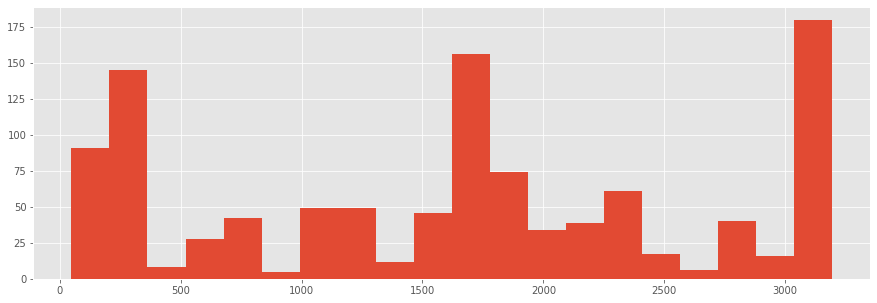

In [3629]:
plt.figure(figsize=(15,5))
plt.hist(df['DefaultBrowsersIdentifier'], bins=20)

In [3630]:
#Too many nulls
#var has no order, no hidden order neither
#we drop this var
df.drop('DefaultBrowsersIdentifier', axis=1, inplace=True)

In [3631]:
#AVProductStatesIdentifier
df['AVProductStatesIdentifier'].describe()

count    24122.000000
mean     47787.219882
std      14102.610777
min         39.000000
25%      49480.000000
50%      53447.000000
75%      53447.000000
max      70486.000000
Name: AVProductStatesIdentifier, dtype: float64

In [3632]:
#only 3% are nulls
df['AVProductStatesIdentifier'].isnull().value_counts()/len(df)

False    0.996736
True     0.003264
Name: AVProductStatesIdentifier, dtype: float64

In [3633]:
#and the 3 vars 'AVProduct...' are not correlated enough to drop any of them
df[['AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled']].corr()

,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled
AVProductStatesIdentifier,1.000000,-0.637089,-0.153018
AVProductsInstalled,-0.637089,1.000000,0.305673
AVProductsEnabled,-0.153018,0.305673,1.000000


In [3634]:
df['AVProductStatesIdentifier'].fillna(-1, inplace=True)

(array([ 2137.,   754.,   945., 18913.,  1452.]),
 array([-1.00000e+00,  1.40964e+04,  2.81938e+04,  4.22912e+04,
         5.63886e+04,  7.04860e+04]),
 <a list of 5 Patch objects>)

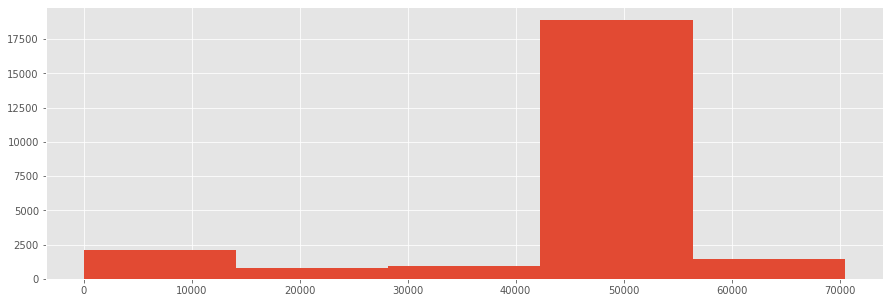

In [3635]:
plt.figure(figsize=(15,5))
plt.hist(df['AVProductStatesIdentifier'], bins=5)

In [3636]:
df.pivot_table(index='AVProductStatesIdentifier', values=TARGET, aggfunc='mean')

,HasDetections
AVProductStatesIdentifier,
-1.0,0.265823
39.0,0.000000
401.0,1.000000
871.0,0.000000
888.0,0.000000
...,...
69777.0,1.000000
69968.0,0.200000
70154.0,0.000000


In [3637]:
#'AVProductsInstalled'
df['AVProductsInstalled'].describe()

count    24122.000000
mean         1.327253
std          0.525249
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: AVProductsInstalled, dtype: float64

In [3638]:
df['AVProductsInstalled'].isnull().value_counts()

False    24122
True        79
Name: AVProductsInstalled, dtype: int64

In [3639]:
df['AVProductsInstalled'].fillna(-1, inplace=True)

In [3640]:
#AVProductsEnabled
df['AVProductsEnabled'].describe()

count    24122.000000
mean         1.022386
std          0.167397
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: AVProductsEnabled, dtype: float64

In [3641]:
df['AVProductsEnabled'].fillna(-1, inplace=True)

In [3642]:
#HasTpm
df['HasTpm'].describe()

count    24201.000000
mean         0.988224
std          0.107880
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HasTpm, dtype: float64

In [3643]:
df['HasTpm'].value_counts()

1    23916
0      285
Name: HasTpm, dtype: int64

In [3644]:
df.pivot_table(index='HasTpm', values=TARGET, aggfunc='mean')

,HasDetections
HasTpm,
0,0.452632
1,0.502258


In [3645]:
#CountryIdentifier
df['CountryIdentifier'].describe()

count    24201.000000
mean       108.020743
std         63.186323
min          1.000000
25%         51.000000
50%         97.000000
75%        162.000000
max        222.000000
Name: CountryIdentifier, dtype: float64

In [3646]:
df.pivot_table(index='CountryIdentifier', values=TARGET, aggfunc='mean')

,HasDetections
CountryIdentifier,
1,0.333333
2,0.463158
3,0.687500
4,0.250000
5,1.000000
...,...
218,0.800000
219,0.000000
220,0.455446


In [3647]:
df['CountryIdentifier'].value_counts()

43     1107
141     959
29      896
171     741
93      728
       ... 
134       1
64        1
75        1
217       1
14        1
Name: CountryIdentifier, Length: 212, dtype: int64

In [3648]:
#CityIdentifier
df['CityIdentifier'].describe()

count     23332.000000
mean      81232.664367
std       48940.701476
min          25.000000
25%       36865.000000
50%       82373.000000
75%      123910.250000
max      167934.000000
Name: CityIdentifier, dtype: float64

In [3649]:
df['CityIdentifier'].value_counts()

130775.0    255
16668.0     234
82373.0     212
10222.0     197
143782.0    189
           ... 
121189.0      1
144076.0      1
139904.0      1
54937.0       1
69792.0       1
Name: CityIdentifier, Length: 6601, dtype: int64

In [3650]:
df['CityIdentifier'].fillna(-1, inplace=True)

In [3651]:
#OrganizationIdentifier
df['OrganizationIdentifier'].describe()

count    16797.000000
mean        24.940406
std          5.644217
min          1.000000
25%         18.000000
50%         27.000000
75%         27.000000
max         52.000000
Name: OrganizationIdentifier, dtype: float64

In [3652]:
df['OrganizationIdentifier'].fillna(-1, inplace=True)

In [3653]:
#GeoNameIdentifier
df['GeoNameIdentifier'].describe()

count    24201.000000
mean       169.675303
std         89.251003
min          1.000000
25%         89.000000
50%        181.000000
75%        267.000000
max        295.000000
Name: GeoNameIdentifier, dtype: float64

In [3654]:
df['GeoNameIdentifier'].fillna(-1, inplace=True)

In [3655]:
#LocaleEnglishNameIdentifier
df['LocaleEnglishNameIdentifier'].describe()

count    24201.000000
mean       122.994174
std         69.552410
min          1.000000
25%         74.000000
50%         88.000000
75%        182.000000
max        278.000000
Name: LocaleEnglishNameIdentifier, dtype: float64

In [3656]:
df['LocaleEnglishNameIdentifier'].isnull().value_counts()

False    24201
Name: LocaleEnglishNameIdentifier, dtype: int64

In [3657]:
#OsBuild
df['OsBuild'].describe()

count    24201.000000
mean     15750.307425
std       2171.699220
min       7600.000000
25%      15063.000000
50%      16299.000000
75%      17134.000000
max      17763.000000
Name: OsBuild, dtype: float64

In [3658]:
df['OsBuild'].isnull().value_counts()

False    24201
Name: OsBuild, dtype: int64

In [3659]:
#OsSuite
df['OsSuite'].describe()

count    24201.000000
mean       573.591587
std        248.490444
min         16.000000
25%        256.000000
50%        768.000000
75%        768.000000
max        784.000000
Name: OsSuite, dtype: float64

In [3660]:
#IsProtected
df['IsProtected'].describe()

count    24122.000000
mean         0.947268
std          0.223502
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: IsProtected, dtype: float64

In [3661]:
df['IsProtected'].value_counts()

1.0    22850
0.0     1272
Name: IsProtected, dtype: int64

In [3662]:
df[['IsProtected', TARGET]].corr()

,IsProtected,HasDetections
IsProtected,1.000000,0.049752
HasDetections,0.049752,1.000000


In [3663]:
#AutoSampleOptIn
df['AutoSampleOptIn'].describe()

count    24201.000000
mean         0.000041
std          0.006428
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: AutoSampleOptIn, dtype: float64

In [3664]:
df['AutoSampleOptIn'].value_counts()

0    24200
1        1
Name: AutoSampleOptIn, dtype: int64

In [3665]:
#There is only one entry for value=1. This is nearly a constant: we drop it
df.drop('AutoSampleOptIn', axis=1, inplace=True)

In [3666]:
#SMode
df['SMode'].describe()

count    22838.000000
mean         0.000657
std          0.025620
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SMode, dtype: float64

In [3667]:
df['SMode'].value_counts()

0.0    22823
1.0       15
Name: SMode, dtype: int64

In [3668]:
#This is a good predictor: all values 1 have TARGET=0
df.pivot_table(index='SMode', values=TARGET, aggfunc='mean')

,HasDetections
SMode,
0.0,0.506769
1.0,0.000000


In [3669]:
df['SMode'].fillna(-1, inplace=True)

In [3670]:
df.pivot_table(index='SMode', values=TARGET, aggfunc='mean')

,HasDetections
SMode,
-1.0,0.421864
0.0,0.506769
1.0,0.000000


In [3671]:
#IeVerIdentifier
df['IeVerIdentifier'].describe()

count    24051.000000
mean       126.369465
std         41.643100
min         15.000000
25%        111.000000
50%        135.000000
75%        137.000000
max        408.000000
Name: IeVerIdentifier, dtype: float64

In [3672]:
df['IeVerIdentifier'].fillna(-1, inplace=True)

In [3673]:
#Firewall
df['Firewall'].describe()

count    23956.000000
mean         0.979254
std          0.142537
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Firewall, dtype: float64

In [3674]:
df['Firewall'].value_counts()

1.0    23459
0.0      497
Name: Firewall, dtype: int64

In [3675]:
#There is 50& chance of TARGET=True per each value of firewall...
df.pivot_table(index='Firewall', values=TARGET, aggfunc='mean')

,HasDetections
Firewall,
0.0,0.509054
1.0,0.501684


In [3676]:
#so we drop this column too: useless for prediction
df.drop('Firewall', axis=1, inplace=True)

In [3677]:
#UacLuaenable
df['UacLuaenable'].describe()

count    24176.000000
mean         0.993754
std          0.078785
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: UacLuaenable, dtype: float64

In [3678]:
df['UacLuaenable'].value_counts()

1.0    24025
0.0      151
Name: UacLuaenable, dtype: int64

In [3679]:
##There is +/- 50& chance of TARGET=True per each value of firewall...
df.pivot_table(index='UacLuaenable', values=TARGET, aggfunc='mean')

,HasDetections
UacLuaenable,
0.0,0.463576
1.0,0.501811


In [3680]:
#so we drop this column too: useless for prediction
df.drop('UacLuaenable', axis=1, inplace=True)

In [3681]:
#Census_OEMNameIdentifier
df['Census_OEMNameIdentifier'].describe()

count    23935.000000
mean      2218.983079
std       1313.950094
min         74.000000
25%       1443.000000
50%       2102.000000
75%       2668.000000
max       6076.000000
Name: Census_OEMNameIdentifier, dtype: float64

In [3682]:
df['Census_OEMNameIdentifier'].fillna(-1, inplace=True)

In [3683]:
#Census_OEMModelIdentifier
df['Census_OEMModelIdentifier'].describe()

count     23923.000000
mean     239779.082473
std       71988.099051
min         150.000000
25%      189846.000000
50%      248045.000000
75%      305865.500000
max      345391.000000
Name: Census_OEMModelIdentifier, dtype: float64

In [3684]:
df['Census_OEMModelIdentifier'].fillna(-1, inplace=True)

In [3685]:
df['Census_OEMModelIdentifier'].value_counts()

 313586.0    828
 242491.0    740
 317701.0    386
 317708.0    331
-1.0         278
            ... 
 224878.0      1
 257647.0      1
 32871.0       1
 60316.0       1
 311294.0      1
Name: Census_OEMModelIdentifier, Length: 6958, dtype: int64

In [3686]:
df[['Census_OEMModelIdentifier', 'Census_OEMNameIdentifier']].corr()

,Census_OEMModelIdentifier,Census_OEMNameIdentifier
Census_OEMModelIdentifier,1.000000,0.125913
Census_OEMNameIdentifier,0.125913,1.000000


In [3687]:
#Census_ProcessorCoreCount
df['Census_ProcessorCoreCount'].describe()

count    24090.000000
mean         3.977750
std          2.085376
min          1.000000
25%          2.000000
50%          4.000000
75%          4.000000
max         56.000000
Name: Census_ProcessorCoreCount, dtype: float64

In [3688]:
df['Census_ProcessorCoreCount'].fillna(-1, inplace=True)

(array([2.1416e+04, 2.4590e+03, 3.0400e+02, 3.0000e+00, 4.0000e+00,
        1.0000e+01, 0.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-1. ,  4.7, 10.4, 16.1, 21.8, 27.5, 33.2, 38.9, 44.6, 50.3, 56. ]),
 <a list of 10 Patch objects>)

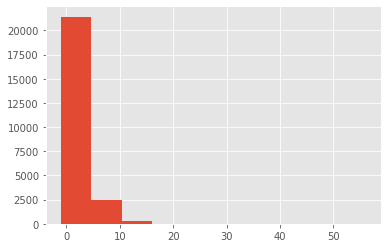

In [3689]:
plt.hist(df['Census_ProcessorCoreCount'])

In [3690]:
#Census_ProcessorManufacturerIdentifier
df['Census_ProcessorManufacturerIdentifier'].describe()

count    24090.000000
mean         4.528269
std          1.290141
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Census_ProcessorManufacturerIdentifier, dtype: float64

In [3691]:
df['Census_ProcessorManufacturerIdentifier'].fillna(-1, inplace=True)

In [3692]:
df['Census_ProcessorManufacturerIdentifier'].value_counts()

 5.0    21249
 1.0     2841
-1.0      111
Name: Census_ProcessorManufacturerIdentifier, dtype: int64

In [3693]:
#this is another var with 50% chance of 'HasDetections'=True...
df.pivot_table(index='Census_ProcessorManufacturerIdentifier', values=TARGET, aggfunc='mean')

,HasDetections
Census_ProcessorManufacturerIdentifier,
-1.0,0.540541
1.0,0.482577
5.0,0.504024


In [3694]:
#so we drop this column too: useless for prediction
df.drop('Census_ProcessorManufacturerIdentifier', axis=1, inplace=True)

In [3695]:
#Census_ProcessorModelIdentifier
df['Census_ProcessorModelIdentifier'].describe()

count    24090.000000
mean      2371.576754
std        844.053784
min         19.000000
25%       1998.000000
50%       2500.000000
75%       2877.000000
max       4469.000000
Name: Census_ProcessorModelIdentifier, dtype: float64

In [3696]:
df['Census_ProcessorModelIdentifier'].fillna(-1, inplace=True)

In [3697]:
#Census_PrimaryDiskTotalCapacity
df['Census_PrimaryDiskTotalCapacity'].describe()

count    2.405700e+04
mean     5.121812e+05
std      3.553856e+05
min      1.024000e+04
25%      2.384750e+05
50%      4.769400e+05
75%      9.538690e+05
max      4.769307e+06
Name: Census_PrimaryDiskTotalCapacity, dtype: float64

In [3698]:
df['Census_PrimaryDiskTotalCapacity'].fillna(-1, inplace=True)

In [3699]:
#Census_SystemVolumeTotalCapacity
df['Census_SystemVolumeTotalCapacity'].describe()

count    2.405700e+04
mean     3.776734e+05
std      3.256786e+05
min      9.689000e+03
25%      1.207050e+05
50%      2.494380e+05
75%      4.759770e+05
max      3.814832e+06
Name: Census_SystemVolumeTotalCapacity, dtype: float64

In [3700]:
df['Census_SystemVolumeTotalCapacity'].fillna(-1, inplace=True)

In [3701]:
#Census_HasOpticalDiskDrive
df['Census_HasOpticalDiskDrive'].describe()

count    24201.000000
mean         0.075741
std          0.264588
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Census_HasOpticalDiskDrive, dtype: float64

In [3702]:
#This is a boolean
df['Census_HasOpticalDiskDrive'].value_counts()

0.0    22368
1.0     1833
Name: Census_HasOpticalDiskDrive, dtype: int64

In [3703]:
df.pivot_table(index='Census_HasOpticalDiskDrive', values=TARGET, aggfunc='mean')

,HasDetections
Census_HasOpticalDiskDrive,
0.0,0.499642
1.0,0.526459


In [3704]:
#Census_TotalPhysicalRAM
df['Census_TotalPhysicalRAM'].describe()

count     23974.000000
mean       6115.599149
std        4754.809331
min        1000.000000
25%        4096.000000
50%        4096.000000
75%        8192.000000
max      131072.000000
Name: Census_TotalPhysicalRAM, dtype: float64

In [3705]:
df['Census_TotalPhysicalRAM'].fillna(-1, inplace=True)

In [3706]:
#Census_InternalPrimaryDiagonalDisplaySizeInInches	
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].describe()

count    24073.000000
mean        16.723807
std          6.025397
min          5.500000
25%         13.900000
50%         15.500000
75%         17.300000
max        142.000000
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: float64

In [3707]:
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'].fillna(-1, inplace=True)

In [3708]:
#Census_InternalPrimaryDisplayResolutionHorizontal	
df['Census_InternalPrimaryDisplayResolutionHorizontal'].describe()

count    24073.000000
mean      1551.461014
std        368.760766
min        600.000000
25%       1366.000000
50%       1366.000000
75%       1920.000000
max       7680.000000
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: float64

In [3709]:
df['Census_InternalPrimaryDisplayResolutionHorizontal'].fillna(-1, inplace=True)

In [3710]:
#Census_InternalPrimaryDisplayResolutionVertical	
df['Census_InternalPrimaryDisplayResolutionVertical'].describe()

count    24073.000000
mean       899.731733
std        215.023617
min        480.000000
25%        768.000000
50%        768.000000
75%       1080.000000
max       4320.000000
Name: Census_InternalPrimaryDisplayResolutionVertical, dtype: float64

In [3711]:
df['Census_InternalPrimaryDisplayResolutionVertical'].fillna(-1, inplace=True)

In [3712]:
#The last 2 vars are highly correlated...
df[['Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalPrimaryDisplayResolutionHorizontal']].corr()

,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalPrimaryDisplayResolutionHorizontal
Census_InternalPrimaryDisplayResolutionVertical,1.000000,0.909649
Census_InternalPrimaryDisplayResolutionHorizontal,0.909649,1.000000


In [3713]:
df[['Census_InternalPrimaryDisplayResolutionVertical', TARGET]].mean()

Census_InternalPrimaryDisplayResolutionVertical    894.967729
HasDetections                                        0.501673
dtype: float64

In [3714]:
df[['Census_InternalPrimaryDisplayResolutionHorizontal', TARGET]].mean()#and have the same TARGET.mean()

Census_InternalPrimaryDisplayResolutionHorizontal    1543.249990
HasDetections                                           0.501673
dtype: float64

In [3715]:
#we can drop one of them:
df.drop('Census_InternalPrimaryDisplayResolutionHorizontal', axis=1, inplace=True)

In [3716]:
#Census_InternalBatteryNumberOfCharges
df['Census_InternalBatteryNumberOfCharges'].describe()

count    2.348700e+04
mean     1.148946e+09
std      1.901252e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.294967e+09
max      4.294967e+09
Name: Census_InternalBatteryNumberOfCharges, dtype: float64

In [3717]:
df['Census_InternalBatteryNumberOfCharges'].fillna(-1, inplace=True)

In [3718]:
#Census_OSBuildNumber
df['Census_OSBuildNumber'].describe()#it has no nulls

count    24201.000000
mean     15866.411388
std       1941.819356
min      10240.000000
25%      15063.000000
50%      16299.000000
75%      17134.000000
max      17763.000000
Name: Census_OSBuildNumber, dtype: float64

In [3719]:
#Census_OSBuildRevision
df['Census_OSBuildRevision'].describe()#it has no nulls

count    24201.000000
mean       974.096484
std       2951.304342
min          0.000000
25%        165.000000
50%        285.000000
75%        547.000000
max      17976.000000
Name: Census_OSBuildRevision, dtype: float64

In [3720]:
df[['Census_OSBuildRevision', TARGET]].mean()

Census_OSBuildRevision    974.096484
HasDetections               0.501673
dtype: float64

In [3721]:
df[['Census_OSBuildNumber', TARGET]].mean()

Census_OSBuildNumber    15866.411388
HasDetections               0.501673
dtype: float64

In [3722]:
dfk = df[[TARGET, 'Census_OSBuildNumber', 'Census_OSBuildRevision']]

In [3723]:
len(dfk[(dfk[TARGET]==1) & (dfk['Census_OSBuildRevision']>-1) & (dfk['Census_OSBuildNumber']>-1)])

12141

In [3724]:
len(df[(df[TARGET]==1)])#Census_OSBuildRevision, Census_OSBuildNumber have exactly the same target values

12141

In [3725]:
df.drop('Census_OSBuildRevision', axis=1, inplace=True)

In [3726]:
#Census_OSInstallLanguageIdentifier
df['Census_OSInstallLanguageIdentifier'].describe()

count    24041.000000
mean        14.671561
std         10.245779
min          1.000000
25%          8.000000
50%          9.000000
75%         22.000000
max         39.000000
Name: Census_OSInstallLanguageIdentifier, dtype: float64

In [3727]:
df['Census_OSInstallLanguageIdentifier'].fillna(-1, inplace=True)

In [3728]:
#Census_OSUILocaleIdentifier
df['Census_OSUILocaleIdentifier'].describe()

count    24201.000000
mean        60.739226
std         45.191832
min          5.000000
25%         31.000000
50%         34.000000
75%        105.000000
max        160.000000
Name: Census_OSUILocaleIdentifier, dtype: float64

In [3729]:
df['Census_OSUILocaleIdentifier'].isnull().value_counts()#has no nulls

False    24201
Name: Census_OSUILocaleIdentifier, dtype: int64

In [3730]:
#Census_IsPortableOperatingSystem
df['Census_IsPortableOperatingSystem'].describe()

count    24201.000000
mean         0.000372
std          0.019281
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Census_IsPortableOperatingSystem, dtype: float64

In [3731]:
df['Census_IsPortableOperatingSystem'].value_counts()

0.0    24192
1.0        9
Name: Census_IsPortableOperatingSystem, dtype: int64

In [3732]:
df.pivot_table(index='Census_IsPortableOperatingSystem', values=TARGET, aggfunc='mean')#there is a differnt TARGET mean: this var has pred value

,HasDetections
Census_IsPortableOperatingSystem,
0.0,0.501612
1.0,0.666667


In [3733]:
#Census_IsFlightingInternal
df['Census_IsFlightingInternal'].describe()

count    4052.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Census_IsFlightingInternal, dtype: float64

In [3734]:
df['Census_IsFlightingInternal'].value_counts()

0.0    4052
Name: Census_IsFlightingInternal, dtype: int64

In [3735]:
df['Census_IsFlightingInternal'].fillna(-1, inplace=True)

In [3736]:
df.pivot_table(index='Census_IsFlightingInternal', values=TARGET, aggfunc=['mean', 'sum']) #There is a slight difference in TARGET mean, so we keep the var

,mean,sum
,HasDetections,HasDetections
Census_IsFlightingInternal,,
-1.0,0.505335,10182.0
0.0,0.483465,1959.0


In [3737]:
#Census_IsFlightsDisabled
df['Census_IsFlightsDisabled'].describe()

count    23805.000000
mean         0.000042
std          0.006481
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Census_IsFlightsDisabled, dtype: float64

In [3738]:
df['Census_IsFlightsDisabled'].value_counts()

0.0    23804
1.0        1
Name: Census_IsFlightsDisabled, dtype: int64

In [3739]:
df['Census_IsFlightsDisabled'].fillna(-1, inplace=True)

In [3740]:
df['Census_IsFlightsDisabled'].value_counts()/len(df)

 0.0    0.983596
-1.0    0.016363
 1.0    0.000041
Name: Census_IsFlightsDisabled, dtype: float64

In [3741]:
df.pivot_table(index='Census_IsFlightsDisabled', values=TARGET, aggfunc='mean')

,HasDetections
Census_IsFlightsDisabled,
-1.0,0.434343
0.0,0.502815
1.0,0.000000


In [3742]:
df.drop('Census_IsFlightsDisabled', axis=1, inplace=True)#98% of this bool var's values are 0, and TARGET mean is 50%... We drop this var


In [3743]:
#Census_ThresholdOptIn
df['Census_ThresholdOptIn'].describe()

count    8761.000000
mean        0.000228
std         0.015108
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Census_ThresholdOptIn, dtype: float64

In [3744]:
df['Census_ThresholdOptIn'].fillna(-1, inplace=True)

In [3745]:
df['Census_ThresholdOptIn'].value_counts()

-1.0    15440
 0.0     8759
 1.0        2
Name: Census_ThresholdOptIn, dtype: int64

In [3746]:
df.pivot_table(index='Census_ThresholdOptIn', values=TARGET, aggfunc='mean')

,HasDetections
Census_ThresholdOptIn,
-1.0,0.509909
0.0,0.487156
1.0,0.500000


In [3747]:
#Census_FirmwareManufacturerIdentifier
df['Census_FirmwareManufacturerIdentifier'].describe()

count    23690.000000
mean       399.502702
std        221.070503
min         33.000000
25%        142.000000
50%        500.000000
75%        556.000000
max       1080.000000
Name: Census_FirmwareManufacturerIdentifier, dtype: float64

In [3748]:
df['Census_FirmwareManufacturerIdentifier'].fillna(-1, inplace=True)

In [3749]:
#Census_FirmwareVersionIdentifier
df['Census_FirmwareVersionIdentifier'].describe()

count    23751.000000
mean     32921.711296
std      21154.908710
min         23.000000
25%      13154.000000
50%      33070.000000
75%      52374.500000
max      72080.000000
Name: Census_FirmwareVersionIdentifier, dtype: float64

In [3750]:
df['Census_FirmwareVersionIdentifier'].fillna(-1, inplace=True)

In [3751]:
#Census_IsSecureBootEnabled
df['Census_IsSecureBootEnabled'].describe()

count    24201.000000
mean         0.481798
std          0.499679
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Census_IsSecureBootEnabled, dtype: float64

In [3752]:
#Census_IsWIMBootEnabled
df['Census_IsWIMBootEnabled'].describe()

count    8782.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Census_IsWIMBootEnabled, dtype: float64

In [3753]:
df['Census_IsWIMBootEnabled'].fillna(-1, inplace=True)

In [3754]:
df[df['Census_IsWIMBootEnabled']==-1][TARGET].mean()

0.5100849601141448

In [3755]:
#Census_IsVirtualDevice
df['Census_IsVirtualDevice'].describe()

count    24145.000000
mean         0.007414
std          0.085784
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Census_IsVirtualDevice, dtype: float64

In [3756]:
df['Census_IsVirtualDevice'].fillna(-1, inplace=True)

In [3757]:
df.pivot_table(index='Census_IsVirtualDevice', values=TARGET, aggfunc='mean')

,HasDetections
Census_IsVirtualDevice,
-1.0,0.410714
0.0,0.504465
1.0,0.156425


In [3758]:
#Census_IsTouchEnabled
df['Census_IsTouchEnabled'].describe()

count    24201.000000
mean         0.126317
std          0.332213
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Census_IsTouchEnabled, dtype: float64

In [3759]:
df['Census_IsTouchEnabled'].value_counts()

0.0    21144
1.0     3057
Name: Census_IsTouchEnabled, dtype: int64

In [3760]:
df.pivot_table(index='Census_IsTouchEnabled', values=TARGET, aggfunc='mean')

,HasDetections
Census_IsTouchEnabled,
0.0,0.510026
1.0,0.443899


In [3761]:
#Census_IsPenCapable
df['Census_IsPenCapable'].describe()

count    24201.000000
mean         0.037684
std          0.190436
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Census_IsPenCapable, dtype: float64

In [3762]:
df.pivot_table(index='Census_IsPenCapable', values=TARGET, aggfunc='mean')

,HasDetections
Census_IsPenCapable,
0.0,0.503070
1.0,0.466009


In [3763]:
#Census_IsAlwaysOnAlwaysConnectedCapable
df['Census_IsAlwaysOnAlwaysConnectedCapable'].describe()

count    24005.000000
mean         0.055905
std          0.229743
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Census_IsAlwaysOnAlwaysConnectedCapable, dtype: float64

In [3764]:
df['Census_IsAlwaysOnAlwaysConnectedCapable'].fillna(-1, inplace=True)

In [3765]:
df.pivot_table(index='Census_IsAlwaysOnAlwaysConnectedCapable', values=TARGET, aggfunc='mean')

,HasDetections
Census_IsAlwaysOnAlwaysConnectedCapable,
-1.0,0.489796
0.0,0.508671
1.0,0.385246


In [3766]:
#Wdft_IsGamer
df['Wdft_IsGamer'].describe()

count    23361.000000
mean         0.286846
std          0.452299
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Wdft_IsGamer, dtype: float64

In [3767]:
df['Wdft_IsGamer'].fillna(-1, inplace=True)

In [3768]:
df.pivot_table(index='Wdft_IsGamer', values=TARGET, aggfunc='mean')

,HasDetections
Wdft_IsGamer,
-1.0,0.514286
0.0,0.480132
1.0,0.553649


In [3769]:
#Wdft_RegionIdentifier
df['Wdft_RegionIdentifier'].describe()

count    23361.000000
mean         7.860237
std          4.537895
min          1.000000
25%          3.000000
50%         10.000000
75%         11.000000
max         15.000000
Name: Wdft_RegionIdentifier, dtype: float64

In [3770]:
df['Wdft_RegionIdentifier'].fillna(-1, inplace=True)

In [3771]:
df_list_numerical = df.select_dtypes(include=['number'])

In [3772]:
df_list_numerical

,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,SMode,IeVerIdentifier,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,Census_OSBuildNumber,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f1cd864e97bae82bdf96523e1a539121,7.0,0,53447.0,1.0,1.0,1,8,85219.0,-1.0,205.0,172,17134,256,1.0,0.0,137.0,1443.0,275891.0,4.0,2273.0,953869.0,952838.0,0.0,8192.0,23.0,1080.0,4.294967e+09,17134.0,27.0,120.0,0.0,-1.0,-1.0,355.0,19951.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0
fd5ba6f5b75325ec0423a6c67cc75942,7.0,0,53447.0,1.0,1.0,1,129,54198.0,-1.0,126.0,124,17134,256,1.0,0.0,137.0,2102.0,248850.0,4.0,2660.0,476940.0,457600.0,0.0,8192.0,13.2,720.0,0.000000e+00,17134.0,18.0,72.0,0.0,-1.0,0.0,486.0,48753.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
4e628391e7cc7c482fb3286f486dbd25,7.0,0,46781.0,2.0,1.0,1,149,122689.0,27.0,181.0,56,10586,768,1.0,0.0,74.0,2206.0,238234.0,4.0,2998.0,244198.0,221251.0,0.0,8192.0,15.5,1080.0,0.000000e+00,10586.0,24.0,109.0,0.0,-1.0,0.0,554.0,33111.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,15.0,0.0
270a2e9d028144a4df12a9e3da79fba5,7.0,0,53447.0,1.0,1.0,1,164,114587.0,27.0,205.0,172,17134,768,1.0,0.0,137.0,525.0,265410.0,8.0,2880.0,228936.0,228321.0,0.0,8192.0,15.5,1080.0,5.770000e+02,17134.0,27.0,120.0,0.0,-1.0,-1.0,142.0,48473.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0
06ca8fa8d32c2abdc5b3577d676b3269,7.0,0,47238.0,2.0,1.0,1,207,72421.0,27.0,277.0,75,17134,256,1.0,0.0,137.0,1443.0,256478.0,4.0,198.0,476940.0,464374.0,0.0,4096.0,15.5,768.0,0.000000e+00,17134.0,8.0,31.0,0.0,-1.0,-1.0,355.0,4343.0,1.0,-1.0,0.0,1.0,0.0,0.0,1.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b21a4c46a4762f1f5a829f3fce72f377,7.0,0,23657.0,2.0,1.0,1,171,13627.0,-1.0,211.0,182,17134,768,1.0,0.0,137.0,-1.0,227561.0,4.0,2706.0,953869.0,480358.0,0.0,8192.0,21.5,1080.0,4.294967e+09,17134.0,29.0,125.0,0.0,-1.0,-1.0,142.0,12463.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
f2749794fc5239e17ecddaea860d11ae,7.0,0,47892.0,2.0,1.0,1,152,58351.0,18.0,184.0,69,16299,768,1.0,0.0,117.0,2206.0,252579.0,2.0,3206.0,228936.0,76699.0,0.0,4096.0,17.1,1024.0,4.294967e+09,16299.0,7.0,30.0,0.0,-1.0,0.0,500.0,16640.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
f4de43370da7ccbbbf41b8a54e1a9787,7.0,0,53447.0,1.0,1.0,1,164,82904.0,27.0,205.0,172,16299,768,1.0,0.0,117.0,2102.0,242491.0,4.0,2373.0,953869.0,937809.0,0.0,8192.0,15.5,768.0,0.000000e+00,16299.0,27.0,120.0,0.0,-1.0,-1.0,554.0,33105.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0


###Var. Categoricals

In [3773]:
df_list_objects = df.select_dtypes(include=[object])

In [3774]:
df_list_objects

,ProductName,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,PuaMode,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_ProcessorClass,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Desktop,Windows.Desktop,NaN,HDD,AllinOne,Desktop,NaN,10.0.17134.165,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail
fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,HDD,Notebook,Mobile,lion,10.0.17134.165,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail
4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,windows10,x64,10.0.0.0,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,NaN,RequireAdmin,Convertible,Windows.Desktop,NaN,SSD,Notebook,Mobile,lion,10.0.10586.1176,amd64,th2_release_sec,Core,CORE,Update,Notify,IS_GENUINE,Retail,Retail
270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,NaN,Notebook,Windows.Desktop,NaN,SSD,Notebook,Mobile,NaN,10.0.17134.286,amd64,rs4_release,Core,CORE,IBSClean,FullAuto,IS_GENUINE,Retail,Retail
06ca8fa8d32c2abdc5b3577d676b3269,win8defender,1.1.15200.1,4.18.1807.18075,1.275.511.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,HDD,Portable,Mobile,NaN,10.0.17134.228,amd64,rs4_release,Professional,PROFESSIONAL,Update,FullAuto,IS_GENUINE,OEM:DM,Retail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b21a4c46a4762f1f5a829f3fce72f377,win8defender,1.1.15100.1,4.13.17134.1,1.273.413.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,RequireAdmin,Desktop,Windows.Desktop,NaN,HDD,Desktop,Desktop,NaN,10.0.17134.165,amd64,rs4_release,CoreSingleLanguage,CORE_SINGLELANGUAGE,UUPUpgrade,FullAuto,INVALID_LICENSE,OEM:NONSLP,Retail
f2749794fc5239e17ecddaea860d11ae,win8defender,1.1.15100.1,4.12.16299.15,1.273.568.0,windows10,x64,10.0.0.0,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,NaN,RequireAdmin,Desktop,Windows.Desktop,NaN,SSD,MiniTower,Workstation,NaN,10.0.16299.547,amd64,rs3_release_svc_escrow,Core,CORE,Update,AutoInstallAndRebootAtMaintenanceTime,IS_GENUINE,Retail,Unknown
f4de43370da7ccbbbf41b8a54e1a9787,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1826.0,windows10,x64,10.0.0.0,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,NaN,ExistsNotSet,Notebook,Windows.Desktop,NaN,HDD,Notebook,Mobile,NaN,10.0.16299.547,amd64,rs3_release_svc_escrow,Core,CORE,UUPUpgrade,AutoInstallAndRebootAtMaintenanceTime,IS_GENUINE,OEM:DM,Retail


In [3775]:
#mapping dicts
ProductName_dict = {'win8defender':1, 'mse':0}
Platform_dict = {'windows10': 4, 'windows8': 3, 'windows7': 2, 'windows2016': 1}
Processor_dict = {'x64': 1, 'x86': 0}
OsVer_dict = {'10.0.0.0': 5, '6.3.0.0': 4, '6.1.1.0': 3, '6.1.0.0': 2, '10.0.0.112': 1, '10.0.3.0': 1}
OsPlatformSubRelease_dict = {'rs4': 9, 'rs3': 8, 'rs2': 7, 'rs1': 6, 'th2': 5, 'th1': 4, 'windows8.1': 3, 'windows7': 2, 'prers5': 1}
SkuEdition_dict = {'Home': 8, 'Pro': 7, 'Invalid': 6, 'Education': 5, 'Enterprise': 4, 'Enterprise LTSB': 3, 'Cloud': 2, 'Server': 1}
SmartScreen_dict = {'RequireAdmin':10, 'zzz': 9, 'ExistsNotSet': 8, 'Off': 7, 'Warn': 6, 'Prompt': 5, 'Block': 4, 'off': 2, 'On': 1, '&#x02': 1}
Census_ProcessorClass_dict = {'zzz': 4, 'mid': 3, 'low': 2, 'high': 1}
Census_PrimaryDiskTypeName_dict = {'HDD':3, 'SSD': 2, 'UNKNOWN':1, 'Unspecified':1, 'zzz':1}
Census_ChassisTypeName_dict = {'Notebook':24, 'Desktop':23, 'Laptop': 22, 'Portable': 21, 'AllinOne': 20, 'MiniTower': 19, 'Convertible': 18, 'Other':17, 'UNKNOWN':17, 'LowProfileDesktop':16, 'Detachable': 15, 'HandHeld':14, 'SpaceSaving':13, 'Unknown':17, 'Tablet':12, 'Tower':11, 'MainServerChassis':10, 'MiniPC':9, 'RackMountChassis':8, 'LunchBox':7, 'BusExpansionChassis':6, 'zzz':17, '32':5, '0':5, 'MultisystemChassis':4, 'SubNotebook':4}
Census_PowerPlatformRoleName_dict = {'Mobile': 8, 'Desktop': 7, 'Slate': 6, 'Workstation':5, 'SOHOServer': 4, 'UNKNOWN': 3, 'EnterpriseServer': 2, 'AppliancePC':1}
Census_InternalBatteryType_dict = {'unknown': 14, 'lion':13, 'li-i':12, '#':14, 'lip':11, 'liio':10, 'li p':9, 'li':8, 'real':7, 'nimh':6, 'vbox':5, 'bq20':4, 'pbac':3, 'lhp0': 2, 'li-l':1, 'unkn':14, 'batt':4, 'ram':4, 'lipo':1, 'lgi0':1}
Census_OSArchitecture_dict = {'amd64':2, 'x86':2}
Census_OSSkuName_dict = {'CORE':14, 'PROFESSIONAL': 13, 'CORE_SINGLELANGUAGE': 12, 'CORE_COUNTRYSPECIFIC': 11, 'EDUCATION':10, 'ENTERPRISE': 9, 'PROFESSIONAL_N':8, 'ENTERPRISE-S': 7, 'STANDARD_SERVER':6, 'CLOUD':5, 'CORE_N':4, 'STANDARD_EVALUATION_SERVER':3, 'EDUCATION_N':2, 'DATACENTER_EVALUATION_SERVER':1, 'SB_SOLUTION_SERVER':1, 'ENTERPRISE_N':1, 'ENTERPRISE_S_N':1}
Census_OSInstallTypeName_dict = {'UUPUpgrade':9, 'IBSClean':8, 'Update':7, 'Upgrade':6, 'Other':5, 'Reset':4, 'Refresh':3, 'Clean':2, 'CleanPCRefresh':1}
Census_OSWUAutoUpdateOptionsName_dict = {'FullAuto':6, 'UNKNOWN':5, 'Notify':4, 'AutoInstallAndRebootAtMaintenanceTime':3, 'Off':2, 'DownloadNotify':1}
Census_GenuineStateName_dict = {'IS_GENUINE':4, 'INVALID_LICENSE':3, 'OFFLINE':2, 'UNKNOWN':1}
Census_ActivationChannel_dict = {'Retail':6, 'OEM:DM':5, 'Volume:GVLK':4, 'OEM:NONSLP':3, 'Volume:MAK':2, 'Retail:TB:Eval':1}
Census_FlightRing_dict = {'Retail':7, 'NOT_SET':6, 'Unknown':6, 'WIS':5, 'WIF':4, 'RP':3, 'Disabled':2, 'OSG':1}

In [3776]:
#'ProductName'
df['ProductName'].describe()

count            24201
unique               2
top       win8defender
freq             23943
Name: ProductName, dtype: object

In [3777]:
#Has only two values, and no nulls
#we map it to boolean values: 0, 

In [3778]:
df['ProductName']=df['ProductName'].map(ProductName_dict)

In [3779]:
#EngineVersion
df['EngineVersion'].describe()

count           24201
unique             36
top       1.1.15200.1
freq            10597
Name: EngineVersion, dtype: object

In [3780]:
df['EngineVersion'].value_counts()

1.1.15200.1    10597
1.1.15100.1     9943
1.1.15000.2      673
1.1.14901.4      574
1.1.14600.4      393
1.1.14800.3      365
1.1.15300.6      347
1.1.14104.0      273
1.1.15300.5      189
1.1.13504.0      185
1.1.14700.5      127
1.1.14500.5      120
1.1.14405.2       84
1.1.14306.0       57
1.1.14202.0       44
1.1.14003.0       30
1.1.13303.0       24
1.1.13407.0       20
1.1.13903.0       19
1.1.13804.0       17
1.1.13704.0       15
1.1.13601.0       14
1.1.13103.0       14
1.1.13000.0       13
1.1.12902.0       13
1.1.14305.0       11
1.1.13701.0       10
1.1.13202.0        8
1.1.15000.1        7
1.1.14800.1        5
1.1.14901.3        3
1.1.12805.0        2
1.1.14700.4        2
1.1.12101.0        1
1.1.14700.3        1
1.1.14201.0        1
Name: EngineVersion, dtype: int64

In [3781]:
df.pivot_table(index='EngineVersion', values=TARGET, aggfunc=[len, np.mean]).columns

MultiIndex([( 'len', 'HasDetections'),
            ('mean', 'HasDetections')],
           )

In [3782]:
df.pivot_table(index='EngineVersion', values=TARGET, aggfunc=[len, np.mean]).sort_values(by=[('len', 'HasDetections')], ascending=False)

,len,mean
,HasDetections,HasDetections
EngineVersion,,
1.1.15200.1,10597.0,0.494385
1.1.15100.1,9943.0,0.548929
1.1.15000.2,673.0,0.365527
1.1.14901.4,574.0,0.346690
1.1.14600.4,393.0,0.440204
1.1.14800.3,365.0,0.309589
1.1.15300.6,347.0,0.489914
1.1.14104.0,273.0,0.373626


In [3783]:
#Frequency Encoding for EngineVersion
df_EngineVersion = pd.DataFrame(df['EngineVersion'].value_counts(dropna=False))

In [3784]:
df_EngineVersion

,EngineVersion
1.1.15200.1,10597
1.1.15100.1,9943
1.1.15000.2,673
1.1.14901.4,574
1.1.14600.4,393
1.1.14800.3,365
1.1.15300.6,347
1.1.14104.0,273
1.1.15300.5,189
1.1.13504.0,185


In [3785]:
df_EngineVersion.columns=['EngineVersion_count']

In [3786]:
df_EngineVersion.index

Index(['1.1.15200.1', '1.1.15100.1', '1.1.15000.2', '1.1.14901.4',
       '1.1.14600.4', '1.1.14800.3', '1.1.15300.6', '1.1.14104.0',
       '1.1.15300.5', '1.1.13504.0', '1.1.14700.5', '1.1.14500.5',
       '1.1.14405.2', '1.1.14306.0', '1.1.14202.0', '1.1.14003.0',
       '1.1.13303.0', '1.1.13407.0', '1.1.13903.0', '1.1.13804.0',
       '1.1.13704.0', '1.1.13601.0', '1.1.13103.0', '1.1.13000.0',
       '1.1.12902.0', '1.1.14305.0', '1.1.13701.0', '1.1.13202.0',
       '1.1.15000.1', '1.1.14800.1', '1.1.14901.3', '1.1.12805.0',
       '1.1.14700.4', '1.1.12101.0', '1.1.14700.3', '1.1.14201.0'],
      dtype='object')

In [3787]:
df_EngineVersion['EngineVersion'] = df_EngineVersion.index

In [3788]:
df_EngineVersion.head(5)

,EngineVersion_count,EngineVersion
1.1.15200.1,10597,1.1.15200.1
1.1.15100.1,9943,1.1.15100.1
1.1.15000.2,673,1.1.15000.2
1.1.14901.4,574,1.1.14901.4
1.1.14600.4,393,1.1.14600.4


In [3789]:
df = df.merge(df_EngineVersion, on='EngineVersion')

In [3790]:
df.drop('EngineVersion', axis=1, inplace=True)

In [3791]:
#AppVersion
df_AppVersion = pd.DataFrame(df['AppVersion'].value_counts(dropna=False))

In [3792]:
df_AppVersion.columns = ['AppVersion_count']

In [3793]:
df_AppVersion['AppVersion'] = df_AppVersion.index

In [3794]:
df = df.merge(df_AppVersion, on='AppVersion')

In [3795]:
df.drop('AppVersion', axis=1, inplace=True)

In [3796]:
#AvSigVersion
df['AvSigVersion'].describe()

count            24201
unique            2240
top       1.273.1420.0
freq               300
Name: AvSigVersion, dtype: object

In [3797]:
#labelencoder
df['AvSigVersion'].unique()

array(['1.273.1234.0', '1.273.1282.0', '1.273.418.0', ..., '1.277.58.0',
       '1.265.699.0', '1.227.2649.0'], dtype=object)

In [3798]:
from sklearn.preprocessing import LabelEncoder

In [3799]:
le=LabelEncoder()

In [3800]:
df['AvSigVersion']=le.fit_transform(df['AvSigVersion'])

In [3801]:
df['AvSigVersion_label']=pd.Series(df['AvSigVersion'])

In [3802]:
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/displayhook.py:260: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


,ProductName,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,PuaMode,SMode,IeVerIdentifier,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,EngineVersion_count,AppVersion_count,AvSigVersion_label
0,1,1359,7.0,0,53447.0,1.0,1.0,1,8,85219.0,-1.0,205.0,172,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,NaN,0.0,137.0,RequireAdmin,Desktop,Windows.Desktop,1443.0,275891.0,4.0,2273.0,NaN,953869.0,HDD,952838.0,0.0,8192.0,AllinOne,23.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134.0,Professional,PROFESSIONAL,UUPUpgrade,27.0,120.0,FullAuto,0.0,IS_GENUINE,OEM:DM,-1.0,Retail,-1.0,355.0,19951.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,9943,14195,1359
1,1,1378,7.0,0,53447.0,1.0,1.0,1,129,54198.0,-1.0,126.0,124,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,NaN,0.0,137.0,RequireAdmin,Notebook,Windows.Desktop,2102.0,248850.0,4.0,2660.0,NaN,476940.0,HDD,457600.0,0.0,8192.0,Notebook,13.2,720.0,Mobile,lion,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134.0,Professional,PROFESSIONAL,UUPUpgrade,18.0,72.0,FullAuto,0.0,IS_GENUINE,OEM:DM,-1.0,Retail,0.0,486.0,48753.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,9943,14195,1378
2,1,1583,7.0,0,46067.0,2.0,1.0,1,80,7182.0,27.0,101.0,107,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,NaN,0.0,137.0,RequireAdmin,Notebook,Windows.Desktop,1443.0,256588.0,4.0,2373.0,NaN,953869.0,HDD,939693.0,0.0,4096.0,Laptop,15.5,768.0,Mobile,NaN,0.000000e+00,10.0.17134.165,amd64,rs4_release,17134.0,Core,CORE,UUPUpgrade,6.0,28.0,FullAuto,0.0,IS_GENUINE,OEM:DM,-1.0,Retail,-1.0,355.0,20106.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,9943,14195,1583
3,1,1451,7.0,0,53447.0,1.0,1.0,1,107,57144.0,27.0,138.0,134,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,NaN,0.0,137.0,NaN,AllInOne,Windows.Desktop,2689.0,111353.0,4.0,2412.0,NaN,122104.0,SSD,104419.0,0.0,4096.0,AllinOne,21.7,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134.0,Core,CORE,Reset,20.0,83.0,FullAuto,0.0,IS_GENUINE,OEM:DM,-1.0,Retail,-1.0,807.0,9834.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9943,14195,1451
4,1,1333,7.0,0,53447.0,1.0,1.0,1,220,40292.0,18.0,237.0,72,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,NaN,0.0,137.0,RequireAdmin,AllInOne,Windows.Desktop,2668.0,210020.0,4.0,2321.0,NaN,476940.0,HDD,450051.0,0.0,4096.0,AllinOne,21.5,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134.0,CoreSingleLanguage,CORE_SINGLELANGUAGE,UUPUpgrade

In [3803]:
df.drop('AvSigVersion', axis=1, inplace=True)

In [3804]:
#Platform
df['Platform'].describe()

count         24201
unique            4
top       windows10
freq          23423
Name: Platform, dtype: object

In [3805]:
df['Platform'].value_counts()

windows10      23423
windows8         479
windows7         255
windows2016       44
Name: Platform, dtype: int64

In [3806]:
#we map Platform to values 1, 2, 3, 4
df['Platform']=df['Platform'].map(Platform_dict)

In [3807]:
df['Platform'].value_counts()

4    23423
3      479
2      255
1       44
Name: Platform, dtype: int64

In [3808]:
#Processor
df['Processor'].describe()

count     24201
unique        2
top         x64
freq      21985
Name: Processor, dtype: object

In [3809]:
df['Processor'].value_counts()

x64    21985
x86     2216
Name: Processor, dtype: int64

In [3810]:
#we map Processor to values 1, 2
df['Processor']=df['Processor'].map(Processor_dict)

In [3811]:
df['Processor'].value_counts()

1    21985
0     2216
Name: Processor, dtype: int64

In [3812]:
#OsVer
df['OsVer'].describe()

count        24201
unique           6
top       10.0.0.0
freq         23465
Name: OsVer, dtype: object

In [3813]:
df['OsVer'].value_counts()

10.0.0.0      23465
6.3.0.0         479
6.1.1.0         251
6.1.0.0           4
10.0.0.112        1
10.0.3.0          1
Name: OsVer, dtype: int64

In [3814]:
df.pivot_table(index='OsVer', values=TARGET, aggfunc=[sum, np.mean])

,sum,mean
,HasDetections,HasDetections
OsVer,,
10.0.0.0,11780.0,0.502024
10.0.0.112,1.0,1.000000
10.0.3.0,1.0,1.000000
6.1.0.0,1.0,0.250000
6.1.1.0,120.0,0.478088
6.3.0.0,238.0,0.496868


In [3815]:
#we map OsVer to values = 5, 4, 3, 2, 1. The last two ones are assigned to 1 (only one instance each, and TARGET = 1)
df['OsVer'] = df['OsVer'].map(OsVer_dict)

In [3816]:
df['OsVer'].value_counts()

5    23465
4      479
3      251
2        4
1        2
Name: OsVer, dtype: int64

In [3817]:
#OsPlatformSubRelease
df['OsPlatformSubRelease'].describe()

count     24201
unique        9
top         rs4
freq      10869
Name: OsPlatformSubRelease, dtype: object

In [3818]:
df['OsPlatformSubRelease'].value_counts()

rs4           10869
rs3            6699
rs2            2058
rs1            1969
th2            1082
th1             745
windows8.1      479
windows7        255
prers5           45
Name: OsPlatformSubRelease, dtype: int64

In [3819]:
df.pivot_table(index='OsPlatformSubRelease', values=TARGET, aggfunc=[sum, np.mean]).sort_values(by=[('sum', 'HasDetections')], ascending=False)

,sum,mean
,HasDetections,HasDetections
OsPlatformSubRelease,,
rs4,5691.0,0.523599
rs3,3335.0,0.497835
rs2,993.0,0.482507
rs1,880.0,0.446927
th2,511.0,0.472274
th1,361.0,0.484564
windows8.1,238.0,0.496868
windows7,121.0,0.474510


In [3820]:
#we map OsPlatformSubRelease to values = 9, 8, 7, 6, 5, 4, 3, 2, 1
df['OsPlatformSubRelease'] = df['OsPlatformSubRelease'].map(OsPlatformSubRelease_dict)

In [3821]:

df['OsPlatformSubRelease'].value_counts()

9    10869
8     6699
7     2058
6     1969
5     1082
4      745
3      479
2      255
1       45
Name: OsPlatformSubRelease, dtype: int64

In [3822]:
#OsBuildLab
df['OsBuildLab'].describe()

count                                        24201
unique                                         263
top       17134.1.amd64fre.rs4_release.180410-1804
freq                                         10138
Name: OsBuildLab, dtype: object

In [3823]:
#we transform to numerical using LabelEncoder
df['OsBuildLab']=le.fit_transform(df['OsBuildLab'])

In [3824]:
df['OsBuildLab_label']=pd.Series(df['OsBuildLab'])

In [3825]:
df.drop('OsBuildLab', axis=1, inplace=True)

In [3826]:
#SkuEdition
df['SkuEdition'].describe()

count     24201
unique        8
top        Home
freq      14871
Name: SkuEdition, dtype: object

In [3827]:
df['SkuEdition'].value_counts()

Home               14871
Pro                 8806
Invalid              225
Education            122
Enterprise            92
Enterprise LTSB       58
Cloud                 14
Server                13
Name: SkuEdition, dtype: int64

In [3828]:
#mapping to a numerical...

In [3829]:
df.pivot_table(index='SkuEdition', values=TARGET, aggfunc=[sum, np.mean])

,sum,mean
,HasDetections,HasDetections
SkuEdition,,
Cloud,6.0,0.428571
Education,66.0,0.540984
Enterprise,42.0,0.456522
Enterprise LTSB,27.0,0.465517
Home,7362.0,0.495057
Invalid,102.0,0.453333
Pro,4534.0,0.514876
Server,2.0,0.153846


In [3830]:
df['SkuEdition'] = df['SkuEdition'].map(SkuEdition_dict)

In [3831]:
df['SkuEdition'].value_counts()

8    14871
7     8806
6      225
5      122
4       92
3       58
2       14
1       13
Name: SkuEdition, dtype: int64

In [3832]:
#PuaMode
df['PuaMode'].describe()

count      6
unique     1
top       on
freq       6
Name: PuaMode, dtype: object

In [3833]:
df['PuaMode'].value_counts()

on    6
Name: PuaMode, dtype: int64

In [3834]:
df['PuaMode'].fillna(-1, inplace=True)

In [3835]:
df['PuaMode'].value_counts()/len(df)

-1    0.999752
on    0.000248
Name: PuaMode, dtype: float64

In [3836]:
df.pivot_table(index='PuaMode', values=TARGET, aggfunc='mean')

,HasDetections
PuaMode,
-1,0.501591
on,0.833333


In [3837]:
#we drop this one
df.drop('PuaMode', axis=1, inplace=True)

In [3838]:
#SmartScreen
df['SmartScreen'].describe()

count            15595
unique               9
top       RequireAdmin
freq             11759
Name: SmartScreen, dtype: object

In [3839]:
df['SmartScreen'].value_counts()

RequireAdmin    11759
ExistsNotSet     2780
Off               517
Warn              377
Prompt             89
Block              63
off                 8
&#x02;              1
On                  1
Name: SmartScreen, dtype: int64

In [3840]:
df['SmartScreen'].fillna('zzz', inplace=True)

In [3841]:
df['SmartScreen'].value_counts()

RequireAdmin    11759
zzz              8606
ExistsNotSet     2780
Off               517
Warn              377
Prompt             89
Block              63
off                 8
&#x02;              1
On                  1
Name: SmartScreen, dtype: int64

In [3842]:
df.pivot_table(index='SmartScreen', values=TARGET, aggfunc=[sum, np.mean])

,sum,mean
,HasDetections,HasDetections
SmartScreen,,
&#x02;,0.0,0.000000
Block,37.0,0.587302
ExistsNotSet,2254.0,0.810791
Off,270.0,0.522244
On,1.0,1.000000
Prompt,43.0,0.483146
RequireAdmin,5193.0,0.441619
Warn,213.0,0.564987


In [3843]:
#We also map SmartScreen: we have assigned the same values to (Off and off), and to (zzz and &#x02)

In [3844]:
df['SmartScreen'] = df['SmartScreen'].map(SmartScreen_dict)

In [3845]:
df['SmartScreen'].value_counts()

10.0    11759
9.0      8606
8.0      2780
7.0       517
6.0       377
5.0        89
4.0        63
2.0         8
1.0         1
Name: SmartScreen, dtype: int64

In [3846]:
#Census_MDC2FormFactor
df['Census_MDC2FormFactor'].describe()

count        24201
unique          11
top       Notebook
freq         15417
Name: Census_MDC2FormFactor, dtype: object

In [3847]:
#Census_MDC2FormFactor
df['Census_MDC2FormFactor'].value_counts()

Notebook        15417
Desktop          5370
Convertible      1085
AllInOne          833
Detachable        820
PCOther           385
LargeTablet       180
SmallTablet        73
SmallServer        24
MediumServer       11
LargeServer         3
Name: Census_MDC2FormFactor, dtype: int64

In [3848]:
df[['Census_MDC2FormFactor',TARGET]].mean()

HasDetections    0.501673
dtype: float64

In [3849]:
#applying LabelEncoder...
df['Census_MDC2FormFactor']=le.fit_transform(df['Census_MDC2FormFactor'])

In [3850]:
df['Census_MDC2FormFactor_label']=pd.Series(df['Census_MDC2FormFactor'])

In [3851]:
df.drop('Census_MDC2FormFactor', axis=1, inplace=True)

In [3852]:
#Census_DeviceFamily
df['Census_DeviceFamily'].describe()

count               24201
unique                  2
top       Windows.Desktop
freq                24156
Name: Census_DeviceFamily, dtype: object

In [3853]:
df['Census_DeviceFamily'].value_counts()/len(df)

Windows.Desktop    0.998141
Windows.Server     0.001859
Name: Census_DeviceFamily, dtype: float64

In [3854]:
df.pivot_table(index='Census_DeviceFamily', values=TARGET, aggfunc=[sum, np.mean])

,sum,mean
,HasDetections,HasDetections
Census_DeviceFamily,,
Windows.Desktop,12127.0,0.502028
Windows.Server,14.0,0.311111


In [3855]:
df.drop('Census_DeviceFamily', axis=1, inplace=True)

In [3856]:
#Census_ProcessorClass
df['Census_ProcessorClass'].describe()

count      87
unique      3
top       mid
freq       48
Name: Census_ProcessorClass, dtype: object

In [3857]:
df['Census_ProcessorClass'].fillna('zzz', inplace=True)

In [3858]:
df['Census_ProcessorClass'].value_counts()

zzz     24114
mid        48
low        22
high       17
Name: Census_ProcessorClass, dtype: int64

In [3859]:
df.pivot_table(index='Census_ProcessorClass', values=TARGET, aggfunc=[sum, np.mean])

,sum,mean
,HasDetections,HasDetections
Census_ProcessorClass,,
high,9.0,0.529412
low,13.0,0.590909
mid,30.0,0.625000
zzz,12089.0,0.501327


In [3860]:
df['Census_ProcessorClass'] = df['Census_ProcessorClass'].map(Census_ProcessorClass_dict)

In [3861]:
df['Census_ProcessorClass'].value_counts()

4    24114
3       48
2       22
1       17
Name: Census_ProcessorClass, dtype: int64

In [3862]:
#Census_PrimaryDiskTypeName
df['Census_PrimaryDiskTypeName'].describe()

count     24169
unique        4
top         HDD
freq      15592
Name: Census_PrimaryDiskTypeName, dtype: object

In [3863]:

df['Census_PrimaryDiskTypeName'].value_counts()

HDD            15592
SSD             6789
UNKNOWN          997
Unspecified      791
Name: Census_PrimaryDiskTypeName, dtype: int64

In [3864]:
df['Census_PrimaryDiskTypeName'].fillna('zzz', inplace=True)

In [3865]:
df.pivot_table(index='Census_PrimaryDiskTypeName', values=TARGET, aggfunc=[sum, np.mean])

,sum,mean
,HasDetections,HasDetections
Census_PrimaryDiskTypeName,,
HDD,7919.0,0.507889
SSD,3414.0,0.502872
UNKNOWN,432.0,0.433300
Unspecified,362.0,0.457649
zzz,14.0,0.437500


In [3866]:
df['Census_PrimaryDiskTypeName'] = df['Census_PrimaryDiskTypeName'].map(Census_PrimaryDiskTypeName_dict)

In [3867]:
#Census_ChassisTypeName
df['Census_ChassisTypeName'].describe()

count        24200
unique          25
top       Notebook
freq         14169
Name: Census_ChassisTypeName, dtype: object

In [3868]:

df['Census_ChassisTypeName'].fillna('zzz', inplace=True)

In [3869]:

df['Census_ChassisTypeName'].value_counts()

Notebook               14169
Desktop                 5157
Laptop                  1846
Portable                 978
AllinOne                 569
MiniTower                224
Convertible              213
Other                    196
UNKNOWN                  180
LowProfileDesktop        146
Detachable               135
HandHeld                 135
SpaceSaving               81
Unknown                   39
Tablet                    34
Tower                     30
MainServerChassis         26
MiniPC                    16
RackMountChassis          12
LunchBox                   7
BusExpansionChassis        3
MultisystemChassis         1
0                          1
32                         1
zzz                        1
SubNotebook                1
Name: Census_ChassisTypeName, dtype: int64

In [3870]:
df.pivot_table(index='Census_ChassisTypeName', values=TARGET, aggfunc='mean')

,HasDetections
Census_ChassisTypeName,
0,1.000000
32,1.000000
AllinOne,0.557118
BusExpansionChassis,0.666667
Convertible,0.455399
Desktop,0.531704
Detachable,0.340741
HandHeld,0.244444
Laptop,0.490791


In [3871]:
df['Census_ChassisTypeName'] = df['Census_ChassisTypeName'].map(Census_ChassisTypeName_dict)

In [3872]:
#Census_PowerPlatformRoleName
df['Census_PowerPlatformRoleName'].describe()

count      24201
unique         8
top       Mobile
freq       16640
Name: Census_PowerPlatformRoleName, dtype: object

In [3873]:

df['Census_PowerPlatformRoleName'].value_counts()

Mobile              16640
Desktop              5708
Slate                1338
Workstation           319
SOHOServer            101
UNKNOWN                65
EnterpriseServer       21
AppliancePC             9
Name: Census_PowerPlatformRoleName, dtype: int64

In [3874]:
df.pivot_table(index='Census_PowerPlatformRoleName', values=TARGET, aggfunc='mean')

,HasDetections
Census_PowerPlatformRoleName,
AppliancePC,0.222222
Desktop,0.536615
EnterpriseServer,0.476190
Mobile,0.500060
SOHOServer,0.524752
Slate,0.377429
UNKNOWN,0.430769
Workstation,0.498433


In [3875]:
df['Census_PowerPlatformRoleName'] = df['Census_PowerPlatformRoleName'].map(Census_PowerPlatformRoleName_dict)

In [3876]:
df['Census_PowerPlatformRoleName'].value_counts()

8    16640
7     5708
6     1338
5      319
4      101
3       65
2       21
1        9
Name: Census_PowerPlatformRoleName, dtype: int64

In [3877]:
#Census_InternalBatteryType
df['Census_InternalBatteryType'].describe()

count     6930
unique      19
top       lion
freq      5439
Name: Census_InternalBatteryType, dtype: object

In [3878]:

df['Census_InternalBatteryType'].value_counts()

lion    5439
li-i     664
#        507
lip      144
liio      91
li p      19
li        18
real      11
nimh      10
bq20       7
vbox       7
pbac       5
lhp0       2
batt       1
li-l       1
lgi0       1
lipo       1
ram        1
unkn       1
Name: Census_InternalBatteryType, dtype: int64

In [3879]:
df['Census_InternalBatteryType'].fillna('unknown', inplace=True)

In [3880]:
df['Census_InternalBatteryType'].value_counts()

unknown    17271
lion        5439
li-i         664
#            507
lip          144
liio          91
li p          19
li            18
real          11
nimh          10
vbox           7
bq20           7
pbac           5
lhp0           2
lipo           1
ram            1
unkn           1
batt           1
lgi0           1
li-l           1
Name: Census_InternalBatteryType, dtype: int64

In [3881]:
df.pivot_table(index='Census_InternalBatteryType', values=TARGET, aggfunc='mean')

,HasDetections
Census_InternalBatteryType,
#,0.536489
batt,0.000000
bq20,0.000000
lgi0,1.000000
lhp0,0.500000
li,0.277778
li p,0.526316
li-i,0.466867
li-l,1.000000


In [3882]:
df['Census_InternalBatteryType'] = df['Census_InternalBatteryType'].map(Census_InternalBatteryType_dict)

In [3883]:
df['Census_InternalBatteryType'].value_counts()

14    17779
13     5439
12      664
11      144
10       91
9        19
8        18
7        11
6        10
4         9
5         7
3         5
1         3
2         2
Name: Census_InternalBatteryType, dtype: int64

In [3884]:
#Census_OSVersion
df['Census_OSVersion'].describe()

count              24201
unique               214
top       10.0.17134.228
freq                3985
Name: Census_OSVersion, dtype: object

In [3885]:
#Frequency Encoding Census_OSVersion
df_Census_OSVersion = pd.DataFrame(df['Census_OSVersion'].value_counts(dropna=False))

In [3886]:
df_Census_OSVersion.columns=['Census_OSVersion_count']

In [3887]:
df_Census_OSVersion['Census_OSVersion'] = df_Census_OSVersion.index

In [3888]:
df_Census_OSVersion.head()

,Census_OSVersion_count,Census_OSVersion
10.0.17134.228,3985,10.0.17134.228
10.0.17134.165,2520,10.0.17134.165
10.0.16299.431,1495,10.0.16299.431
10.0.17134.285,1301,10.0.17134.285
10.0.17134.112,946,10.0.17134.112


In [3889]:
df = df.merge(df_Census_OSVersion, on='Census_OSVersion')

In [3890]:
df.drop('Census_OSVersion', axis=1, inplace=True)

In [3891]:
#Census_OSArchitecture
df['Census_OSArchitecture'].describe()

count     24201
unique        2
top       amd64
freq      21981
Name: Census_OSArchitecture, dtype: object

In [3892]:

df['Census_OSArchitecture'].value_counts()

amd64    21981
x86       2220
Name: Census_OSArchitecture, dtype: int64

In [3893]:
df.pivot_table(index='Census_OSArchitecture', values=TARGET, aggfunc='mean')

,HasDetections
Census_OSArchitecture,
amd64,0.514262
x86,0.377027


In [3894]:
df['Census_OSArchitecture'] = df['Census_OSArchitecture'].map(Census_OSArchitecture_dict)

In [3895]:
#Census_OSBranch
df['Census_OSBranch'].describe()

count           24201
unique             13
top       rs4_release
freq            11136
Name: Census_OSBranch, dtype: object

In [3896]:

df['Census_OSBranch'].value_counts()

rs4_release                  11136
rs3_release                   3315
rs3_release_svc_escrow        3206
rs1_release                   2114
rs2_release                   2099
th2_release                    844
th2_release_sec                676
th1_st1                        536
th1                            211
rs5_release                     34
rs3_release_svc_escrow_im       18
rs_prerelease                    6
rs_prerelease_flt                6
Name: Census_OSBranch, dtype: int64

In [3897]:
df.pivot_table(index='Census_OSBranch', values=TARGET, aggfunc=np.mean)

,HasDetections
Census_OSBranch,
rs1_release,0.453169
rs2_release,0.481182
rs3_release,0.479035
rs3_release_svc_escrow,0.514036
rs3_release_svc_escrow_im,0.222222
rs4_release,0.525413
rs5_release,0.235294
rs_prerelease,0.166667
rs_prerelease_flt,0.333333


In [3898]:
#LabelEncoding...
df['Census_OSBranch']=le.fit_transform(df['Census_OSBranch'])

In [3899]:
df['Census_OSBranch_label']=pd.Series(df['Census_OSBranch'])

In [3900]:
df.drop('Census_OSBranch', axis=1, inplace=True)

In [3901]:
#Census_OSEdition
df['Census_OSEdition'].describe()

count     24201
unique       18
top        Core
freq       9378
Name: Census_OSEdition, dtype: object

In [3902]:
df[['Census_OSEdition', TARGET]].mean()

HasDetections    0.501673
dtype: float64

In [3903]:
#Labelencoding...
df['Census_OSEdition'] = le.fit_transform(df['Census_OSEdition'])

In [3904]:
df['Census_OSEdition_label']=pd.Series(df['Census_OSEdition'])

In [3905]:
df.drop('Census_OSEdition', axis=1, inplace=True)

In [3906]:
#Census_OSSkuName
df['Census_OSSkuName'].describe()

count     24201
unique       17
top        CORE
freq       9379
Name: Census_OSSkuName, dtype: object

In [3907]:

df['Census_OSSkuName'].value_counts()

CORE                            9379
PROFESSIONAL                    8726
CORE_SINGLELANGUAGE             5230
CORE_COUNTRYSPECIFIC             438
EDUCATION                        120
ENTERPRISE                        95
PROFESSIONAL_N                    76
ENTERPRISE_S                      57
STANDARD_SERVER                   30
CLOUD                             14
CORE_N                            13
STANDARD_EVALUATION_SERVER        10
EDUCATION_N                        5
DATACENTER_EVALUATION_SERVER       3
ENTERPRISE_N                       2
SB_SOLUTION_SERVER                 2
ENTERPRISE_S_N                     1
Name: Census_OSSkuName, dtype: int64

In [3908]:
df.pivot_table(index='Census_OSSkuName', values=TARGET, aggfunc='mean')

,HasDetections
Census_OSSkuName,
CLOUD,0.428571
CORE,0.473718
CORE_COUNTRYSPECIFIC,0.531963
CORE_N,0.307692
CORE_SINGLELANGUAGE,0.529063
DATACENTER_EVALUATION_SERVER,0.000000
EDUCATION,0.533333
EDUCATION_N,0.800000
ENTERPRISE,0.484211


In [3909]:
df['Census_OSSkuName'] = df['Census_OSSkuName'].map(Census_OSSkuName_dict)

In [3910]:
df['Census_OSSkuName'].value_counts()

14.0    9379
13.0    8726
12.0    5230
11.0     438
10.0     120
9.0       95
8.0       76
6.0       30
5.0       14
4.0       13
3.0       10
1.0        8
2.0        5
Name: Census_OSSkuName, dtype: int64

In [3911]:
#Census_OSInstallTypeName
df['Census_OSInstallTypeName'].describe()

count          24201
unique             9
top       UUPUpgrade
freq            7165
Name: Census_OSInstallTypeName, dtype: object

In [3912]:
df['Census_OSInstallTypeName'].value_counts()

UUPUpgrade        7165
IBSClean          4503
Update            4219
Upgrade           3392
Other             2218
Reset             1779
Refresh            593
Clean              183
CleanPCRefresh     149
Name: Census_OSInstallTypeName, dtype: int64

In [3913]:
df.pivot_table(index='Census_OSInstallTypeName', values=TARGET, aggfunc='mean')

,HasDetections
Census_OSInstallTypeName,
Clean,0.530055
CleanPCRefresh,0.469799
IBSClean,0.525427
Other,0.483318
Refresh,0.443508
Reset,0.496346
UUPUpgrade,0.528123
Update,0.480920
Upgrade,0.464917


In [3914]:
df['Census_OSInstallTypeName'] = df['Census_OSInstallTypeName'].map(Census_OSInstallTypeName_dict)

In [3915]:
#Census_OSWUAutoUpdateOptionsName
df['Census_OSWUAutoUpdateOptionsName'].describe()

count        24201
unique           6
top       FullAuto
freq         10926
Name: Census_OSWUAutoUpdateOptionsName, dtype: object

In [3916]:
df.pivot_table(index='Census_OSWUAutoUpdateOptionsName', values=TARGET, aggfunc='mean')

,HasDetections
Census_OSWUAutoUpdateOptionsName,
AutoInstallAndRebootAtMaintenanceTime,0.499469
DownloadNotify,0.295455
FullAuto,0.516200
Notify,0.480987
Off,0.439394
UNKNOWN,0.497187


In [3917]:
df['Census_OSWUAutoUpdateOptionsName'].value_counts()

FullAuto                                 10926
UNKNOWN                                   6754
Notify                                    5470
AutoInstallAndRebootAtMaintenanceTime      941
Off                                         66
DownloadNotify                              44
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64

In [3918]:
df['Census_OSWUAutoUpdateOptionsName'] = df['Census_OSWUAutoUpdateOptionsName'].map(Census_OSWUAutoUpdateOptionsName_dict)

In [3919]:
df['Census_OSWUAutoUpdateOptionsName'].value_counts()

6    10926
5     6754
4     5470
3      941
2       66
1       44
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64

In [3920]:
#Census_GenuineStateName
df['Census_GenuineStateName'].describe()

count          24201
unique             4
top       IS_GENUINE
freq           21350
Name: Census_GenuineStateName, dtype: object

In [3921]:

df['Census_GenuineStateName'].value_counts()

IS_GENUINE         21350
INVALID_LICENSE     2178
OFFLINE              629
UNKNOWN               44
Name: Census_GenuineStateName, dtype: int64

In [3922]:
df.pivot_table(index='Census_GenuineStateName', values=TARGET, aggfunc=np.mean)

,HasDetections
Census_GenuineStateName,
INVALID_LICENSE,0.509642
IS_GENUINE,0.501452
OFFLINE,0.492846
UNKNOWN,0.340909


In [3923]:
df['Census_GenuineStateName'] = df['Census_GenuineStateName'].map(Census_GenuineStateName_dict)

In [3924]:
df['Census_GenuineStateName'].value_counts()

4    21350
3     2178
2      629
1       44
Name: Census_GenuineStateName, dtype: int64

In [3925]:
#Census_ActivationChannel
df['Census_ActivationChannel'].describe()

count      24201
unique         6
top       Retail
freq       12799
Name: Census_ActivationChannel, dtype: object

In [3926]:
df.pivot_table(index='Census_ActivationChannel', values=TARGET, aggfunc='mean')

,HasDetections
Census_ActivationChannel,
OEM:DM,0.501402
OEM:NONSLP,0.537694
Retail,0.488476
Retail:TB:Eval,0.153846
Volume:GVLK,0.623019
Volume:MAK,0.375000


In [3927]:
df['Census_ActivationChannel'].value_counts()

Retail            12799
OEM:DM             9272
Volume:GVLK        1199
OEM:NONSLP          902
Volume:MAK           16
Retail:TB:Eval       13
Name: Census_ActivationChannel, dtype: int64

In [3928]:
df['Census_ActivationChannel'] = df['Census_ActivationChannel'].map(Census_ActivationChannel_dict)

In [3929]:
df['Census_ActivationChannel'].value_counts()

6    12799
5     9272
4     1199
3      902
2       16
1       13
Name: Census_ActivationChannel, dtype: int64

In [3930]:
#Census_FlightRing
df['Census_FlightRing'].describe()

count      24201
unique         8
top       Retail
freq       22660
Name: Census_FlightRing, dtype: object

In [3931]:
df['Census_FlightRing'].value_counts()

Retail      22660
NOT_SET       794
Unknown       676
WIS            22
WIF            21
RP             18
Disabled        9
OSG             1
Name: Census_FlightRing, dtype: int64

In [3932]:
df.pivot_table(index='Census_FlightRing', values=TARGET, aggfunc='mean')

,HasDetections
Census_FlightRing,
Disabled,0.222222
NOT_SET,0.498741
OSG,0.000000
RP,0.777778
Retail,0.503354
Unknown,0.463018
WIF,0.285714
WIS,0.181818


In [3933]:
df['Census_FlightRing'] = df['Census_FlightRing'].map(Census_FlightRing_dict)

In [3934]:
df['Census_FlightRing'].value_counts()

7    22660
6     1470
5       22
4       21
3       18
2        9
1        1
Name: Census_FlightRing, dtype: int64

In [3935]:
df_list_objects = df.select_dtypes(include=[object])

In [3936]:
df_list_objects.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,24161,24162,24163,24164,24165,24166,24167,24168,24169,24170,24171,24172,24173,24174,24175,24176,24177,24178,24179,24180,24181,24182,24183,24184,24185,24186,24187,24188,24189,24190,24191,24192,24193,24194,24195,24196,24197,24198,24199,24200


In [3937]:
df_list_numerical = df.select_dtypes(include=['number'])

In [3938]:
df_list_numerical

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,SMode,IeVerIdentifier,SmartScreen,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBuildNumber,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,EngineVersion_count,AppVersion_count,AvSigVersion_label,OsBuildLab_label,Census_MDC2FormFactor_label,Census_OSVersion_count,Census_OSBranch_label,Census_OSEdition_label
0,1,7.0,0,53447.0,1.0,1.0,1,8,85219.0,-1.0,205.0,172,4,1,5,17134,256,9,7,1.0,0.0,137.0,10.0,1443.0,275891.0,4.0,2273.0,4,953869.0,3,952838.0,0.0,8192.0,20,23.0,1080.0,7,14,4.294967e+09,2,17134.0,13.0,9,27.0,120.0,6,0.0,4,5,-1.0,7,-1.0,355.0,19951.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,9943,14195,1359,168,2,2520,5,11
1,1,7.0,0,53447.0,1.0,1.0,1,129,54198.0,-1.0,126.0,124,4,1,5,17134,256,9,7,1.0,0.0,137.0,10.0,2102.0,248850.0,4.0,2660.0,4,476940.0,3,457600.0,0.0,8192.0,24,13.2,720.0,8,13,0.000000e+00,2,17134.0,13.0,9,18.0,72.0,6,0.0,4,5,-1.0,7,0.0,486.0,48753.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,9943,14195,1378,168,7,2520,5,11
2,1,7.0,0,46067.0,2.0,1.0,1,80,7182.0,27.0,101.0,107,4,1,5,17134,768,9,8,1.0,0.0,137.0,10.0,1443.0,256588.0,4.0,2373.0,4,953869.0,3,939693.0,0.0,4096.0,22,15.5,768.0,8,14,0.000000e+00,2,17134.0,14.0,9,6.0,28.0,6,0.0,4,5,-1.0,7,-1.0,355.0,20106.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,9943,14195,1583,168,7,2520,5,1
3,1,7.0,0,53447.0,1.0,1.0,1,107,57144.0,27.0,138.0,134,4,1,5,17134,768,9,8,1.0,0.0,137.0,9.0,2689.0,111353.0,4.0,2412.0,4,122104.0,2,104419.0,0.0,4096.0,20,21.7,1080.0,7,14,4.294967e+09,2,17134.0,14.0,4,20.0,83.0,6,0.0,4,5,-1.0,7,-1.0,807.0,9834.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9943,14195,1451,168,0,2520,5,1
4,1,7.0,0,53447.0,1.0,1.0,1,220,40292.0,18.0,237.0,72,4,1,5,17134,768,9,8,1.0,0.0,137.0,10.0,2668.0,210020.0,4.0,2321.0,4,476940.0,3,450051.0,0.0,4096.0,20,21.5,1080.0,7,14,4.294967e+09,2,17134.0,12.0,9,8.0,31.0,6,0.0,4,6,0.0,7,0.0,628.0,49991.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,1.0,9943,14195,1333,168,0,2520,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24196,1,7.0,0,62773.0,1.0,1.0,1,89,66953.0,27.0,277.0,75,4,0,5,10240,256,4,3,0.0,0.0,63.0,10.0,525.0,331124.0,2.0,2010.0,4,476940.0,3,64650.0,0.0,2048.0,24,14.0,768.0,8,13,0.000000e+00,2,10240.0,NaN,8,8.0,31.0,5,0.0,4,4,0.0,7,0.0,142.0,69591.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,574,1,912,33,7,4,9,9
24197,1,7.0,0,53447.0,1.0,1.0,1,89,66953.0,27.0,120.0,118,4,1,5,10240,256,4,7,1.0,0.0,51.0,8.0,525.0,331096.0,2.0,1992.0,4,476940.0,3,149500.0,0.0,2048.0,24,13.9,768.0,8,13,0.000000e+00,2,10240.0,13.0,8,8.0,31.0,5,0.0,3,6,-1.0,6,

In [3939]:
df

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,SMode,IeVerIdentifier,SmartScreen,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBuildNumber,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,EngineVersion_count,AppVersion_count,AvSigVersion_label,OsBuildLab_label,Census_MDC2FormFactor_label,Census_OSVersion_count,Census_OSBranch_label,Census_OSEdition_label
0,1,7.0,0,53447.0,1.0,1.0,1,8,85219.0,-1.0,205.0,172,4,1,5,17134,256,9,7,1.0,0.0,137.0,10.0,1443.0,275891.0,4.0,2273.0,4,953869.0,3,952838.0,0.0,8192.0,20,23.0,1080.0,7,14,4.294967e+09,2,17134.0,13.0,9,27.0,120.0,6,0.0,4,5,-1.0,7,-1.0,355.0,19951.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,9943,14195,1359,168,2,2520,5,11
1,1,7.0,0,53447.0,1.0,1.0,1,129,54198.0,-1.0,126.0,124,4,1,5,17134,256,9,7,1.0,0.0,137.0,10.0,2102.0,248850.0,4.0,2660.0,4,476940.0,3,457600.0,0.0,8192.0,24,13.2,720.0,8,13,0.000000e+00,2,17134.0,13.0,9,18.0,72.0,6,0.0,4,5,-1.0,7,0.0,486.0,48753.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,9943,14195,1378,168,7,2520,5,11
2,1,7.0,0,46067.0,2.0,1.0,1,80,7182.0,27.0,101.0,107,4,1,5,17134,768,9,8,1.0,0.0,137.0,10.0,1443.0,256588.0,4.0,2373.0,4,953869.0,3,939693.0,0.0,4096.0,22,15.5,768.0,8,14,0.000000e+00,2,17134.0,14.0,9,6.0,28.0,6,0.0,4,5,-1.0,7,-1.0,355.0,20106.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,9943,14195,1583,168,7,2520,5,1
3,1,7.0,0,53447.0,1.0,1.0,1,107,57144.0,27.0,138.0,134,4,1,5,17134,768,9,8,1.0,0.0,137.0,9.0,2689.0,111353.0,4.0,2412.0,4,122104.0,2,104419.0,0.0,4096.0,20,21.7,1080.0,7,14,4.294967e+09,2,17134.0,14.0,4,20.0,83.0,6,0.0,4,5,-1.0,7,-1.0,807.0,9834.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9943,14195,1451,168,0,2520,5,1
4,1,7.0,0,53447.0,1.0,1.0,1,220,40292.0,18.0,237.0,72,4,1,5,17134,768,9,8,1.0,0.0,137.0,10.0,2668.0,210020.0,4.0,2321.0,4,476940.0,3,450051.0,0.0,4096.0,20,21.5,1080.0,7,14,4.294967e+09,2,17134.0,12.0,9,8.0,31.0,6,0.0,4,6,0.0,7,0.0,628.0,49991.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,1.0,9943,14195,1333,168,0,2520,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24196,1,7.0,0,62773.0,1.0,1.0,1,89,66953.0,27.0,277.0,75,4,0,5,10240,256,4,3,0.0,0.0,63.0,10.0,525.0,331124.0,2.0,2010.0,4,476940.0,3,64650.0,0.0,2048.0,24,14.0,768.0,8,13,0.000000e+00,2,10240.0,NaN,8,8.0,31.0,5,0.0,4,4,0.0,7,0.0,142.0,69591.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,574,1,912,33,7,4,9,9
24197,1,7.0,0,53447.0,1.0,1.0,1,89,66953.0,27.0,120.0,118,4,1,5,10240,256,4,7,1.0,0.0,51.0,8.0,525.0,331096.0,2.0,1992.0,4,476940.0,3,149500.0,0.0,2048.0,24,13.9,768.0,8,13,0.000000e+00,2,10240.0,13.0,8,8.0,31.0,5,0.0,3,6,-1.0,6,

In [3940]:
df.isnull().value_counts()

ProductName  RtpStateBitfield  IsSxsPassiveMode  AVProductStatesIdentifier  AVProductsInstalled  AVProductsEnabled  HasTpm  CountryIdentifier  CityIdentifier  OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  Platform  Processor  OsVer  OsBuild  OsSuite  OsPlatformSubRelease  SkuEdition  IsProtected  SMode  IeVerIdentifier  SmartScreen  Census_OEMNameIdentifier  Census_OEMModelIdentifier  Census_ProcessorCoreCount  Census_ProcessorModelIdentifier  Census_ProcessorClass  Census_PrimaryDiskTotalCapacity  Census_PrimaryDiskTypeName  Census_SystemVolumeTotalCapacity  Census_HasOpticalDiskDrive  Census_TotalPhysicalRAM  Census_ChassisTypeName  Census_InternalPrimaryDiagonalDisplaySizeInInches  Census_InternalPrimaryDisplayResolutionVertical  Census_PowerPlatformRoleName  Census_InternalBatteryType  Census_InternalBatteryNumberOfCharges  Census_OSArchitecture  Census_OSBuildNumber  Census_OSSkuName  Census_OSInstallTypeName  Census_OSInstallLanguageIdentifier  Census_OS

In [3941]:
df['IsProtected'].fillna(-1, inplace=True)

In [3942]:
df['SmartScreen'].fillna(-1, inplace=True)

In [3943]:
df['Census_OSSkuName'].fillna(-1, inplace=True)

In [3944]:
df.isnull().value_counts()

ProductName  RtpStateBitfield  IsSxsPassiveMode  AVProductStatesIdentifier  AVProductsInstalled  AVProductsEnabled  HasTpm  CountryIdentifier  CityIdentifier  OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  Platform  Processor  OsVer  OsBuild  OsSuite  OsPlatformSubRelease  SkuEdition  IsProtected  SMode  IeVerIdentifier  SmartScreen  Census_OEMNameIdentifier  Census_OEMModelIdentifier  Census_ProcessorCoreCount  Census_ProcessorModelIdentifier  Census_ProcessorClass  Census_PrimaryDiskTotalCapacity  Census_PrimaryDiskTypeName  Census_SystemVolumeTotalCapacity  Census_HasOpticalDiskDrive  Census_TotalPhysicalRAM  Census_ChassisTypeName  Census_InternalPrimaryDiagonalDisplaySizeInInches  Census_InternalPrimaryDisplayResolutionVertical  Census_PowerPlatformRoleName  Census_InternalBatteryType  Census_InternalBatteryNumberOfCharges  Census_OSArchitecture  Census_OSBuildNumber  Census_OSSkuName  Census_OSInstallTypeName  Census_OSInstallLanguageIdentifier  Census_OS

##MLC 4 Modelling

###MLC 4.1 Train/Test split

In [3945]:
from sklearn import model_selection
from sklearn import metrics

####Development/Validation

In [3946]:
df.pivot_table(index = ['ProductName', 'AVProductStatesIdentifier'], values = TARGET, aggfunc= [len, sum, np.mean])

len           sum          mean
                                      HasDetections HasDetections HasDetections
ProductName AVProductStatesIdentifier                                          
0           871.0                               1.0           0.0      0.000000
            2060.0                              1.0           1.0      1.000000
            2063.0                              8.0           5.0      0.625000
            4663.0                              1.0           0.0      0.000000
            4786.0                              9.0           4.0      0.444444
...                                             ...           ...           ...
1           69725.0                             1.0           0.0      0.000000
            69968.0                             5.0           1.0      0.200000
            70154.0                             1.0           0.0      0.000000
            70262.0                            21.0           8.0      0.380952
            70486.0                             1.0           0.0      0.000000

[907 rows x 3 columns]

(array([1.0000e+00, 1.0000e+00, 8.0000e+00, 0.0000e+00, 6.3000e+01,
        8.9000e+01, 3.7700e+02, 5.1700e+02, 2.7800e+03, 2.0365e+04]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <a list of 10 Patch objects>)

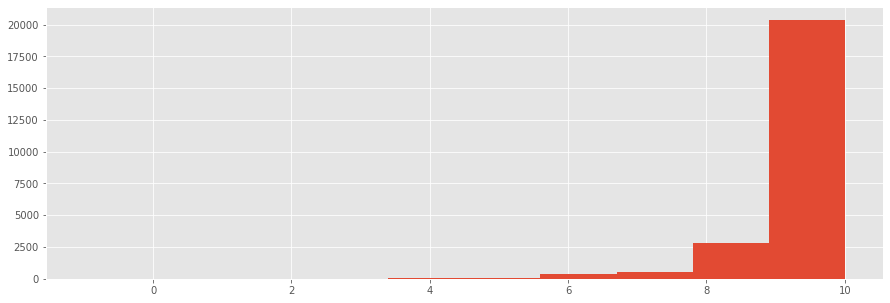

In [3947]:
plt.figure(figsize=(15,5))
plt.hist(df['SmartScreen'], bins=10)

(array([ 2137.,   754.,   945., 18913.,  1452.]),
 array([-1.00000e+00,  1.40964e+04,  2.81938e+04,  4.22912e+04,
         5.63886e+04,  7.04860e+04]),
 <a list of 5 Patch objects>)

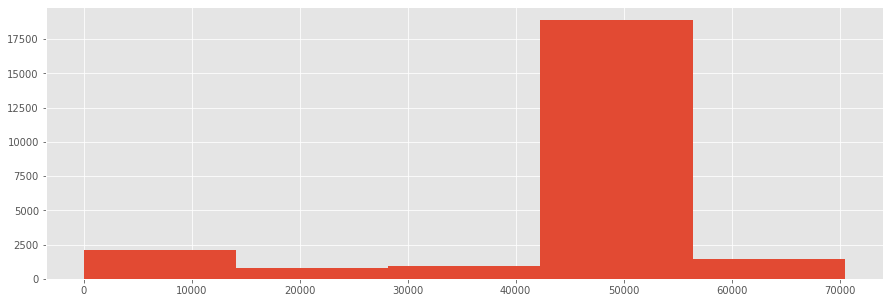

In [3948]:
plt.figure(figsize=(15,5))
plt.hist(df['AVProductStatesIdentifier'], bins=5)

In [3949]:
#dev_df = df[(df['AVProductStatesIdentifier'] > 40000) & (df['AVProductStatesIdentifier'] < 60000)] #development: train/test

In [3950]:
#val_df = df[(df['AVProductStatesIdentifier'] < 40000) | (df['AVProductStatesIdentifier'] > 60000)] #validation

In [3951]:
dev_df = df[(df['SmartScreen'] > 3) & (df['SmartScreen'] < 10)] #development: train/test

In [3952]:
val_df = df[(df['SmartScreen'] < 3) | (df['SmartScreen'] ==10)] #validation

In [3953]:
val_df.shape

(11769, 71)

In [3954]:
dev_df.shape

(12432, 71)

In [3955]:
dev_df.isnull().value_counts()

ProductName  RtpStateBitfield  IsSxsPassiveMode  AVProductStatesIdentifier  AVProductsInstalled  AVProductsEnabled  HasTpm  CountryIdentifier  CityIdentifier  OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  Platform  Processor  OsVer  OsBuild  OsSuite  OsPlatformSubRelease  SkuEdition  IsProtected  SMode  IeVerIdentifier  SmartScreen  Census_OEMNameIdentifier  Census_OEMModelIdentifier  Census_ProcessorCoreCount  Census_ProcessorModelIdentifier  Census_ProcessorClass  Census_PrimaryDiskTotalCapacity  Census_PrimaryDiskTypeName  Census_SystemVolumeTotalCapacity  Census_HasOpticalDiskDrive  Census_TotalPhysicalRAM  Census_ChassisTypeName  Census_InternalPrimaryDiagonalDisplaySizeInInches  Census_InternalPrimaryDisplayResolutionVertical  Census_PowerPlatformRoleName  Census_InternalBatteryType  Census_InternalBatteryNumberOfCharges  Census_OSArchitecture  Census_OSBuildNumber  Census_OSSkuName  Census_OSInstallTypeName  Census_OSInstallLanguageIdentifier  Census_OS

In [3956]:
dev_df_X = dev_df.drop(TARGET,axis = 1)
dev_df_y = dev_df[TARGET]

In [3957]:
dev_df_y.value_counts()

1.0    6941
0.0    5491
Name: HasDetections, dtype: int64

In [3958]:
val_df_X = val_df.drop(TARGET,axis = 1)
val_df_y = val_df[TARGET]

In [3959]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    dev_df_X,
    dev_df_y,
    test_size = 0.2, #20% of development to test, 80% to train
    random_state = 42
)

### MLC 4.2 Defining Model

In [3960]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [3961]:
#1. Model Instance

dt = DecisionTreeClassifier(
    
        #criterion="gini",
        #splitter="best",
        max_depth=4, #number of queries
        min_samples_split=20, #minimum amount of obs after querying
        min_samples_leaf=1, #minimum amount of obs in final node
        #min_weight_fraction_leaf=0.0,
        #max_features=None,
        random_state=42
        #max_leaf_nodes=None,
        #min_impurity_decrease=0.0,
        #class_weight=None,
        #ccp_alpha=0.0,

)

In [3962]:
#2. Training Model

dt.fit(
   X=X_train,
   y=y_train
)

DecisionTreeClassifier(max_depth=4, min_samples_split=20, random_state=42)

In [3963]:
dot_data = export_graphviz(
    
    decision_tree = dt,
    out_file=None,
    #max_depth=None,
    feature_names=X_test.columns,
    class_names=['No Detections', 'Detections'],
    #label="all",
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
    #fontname="helvetica"

)

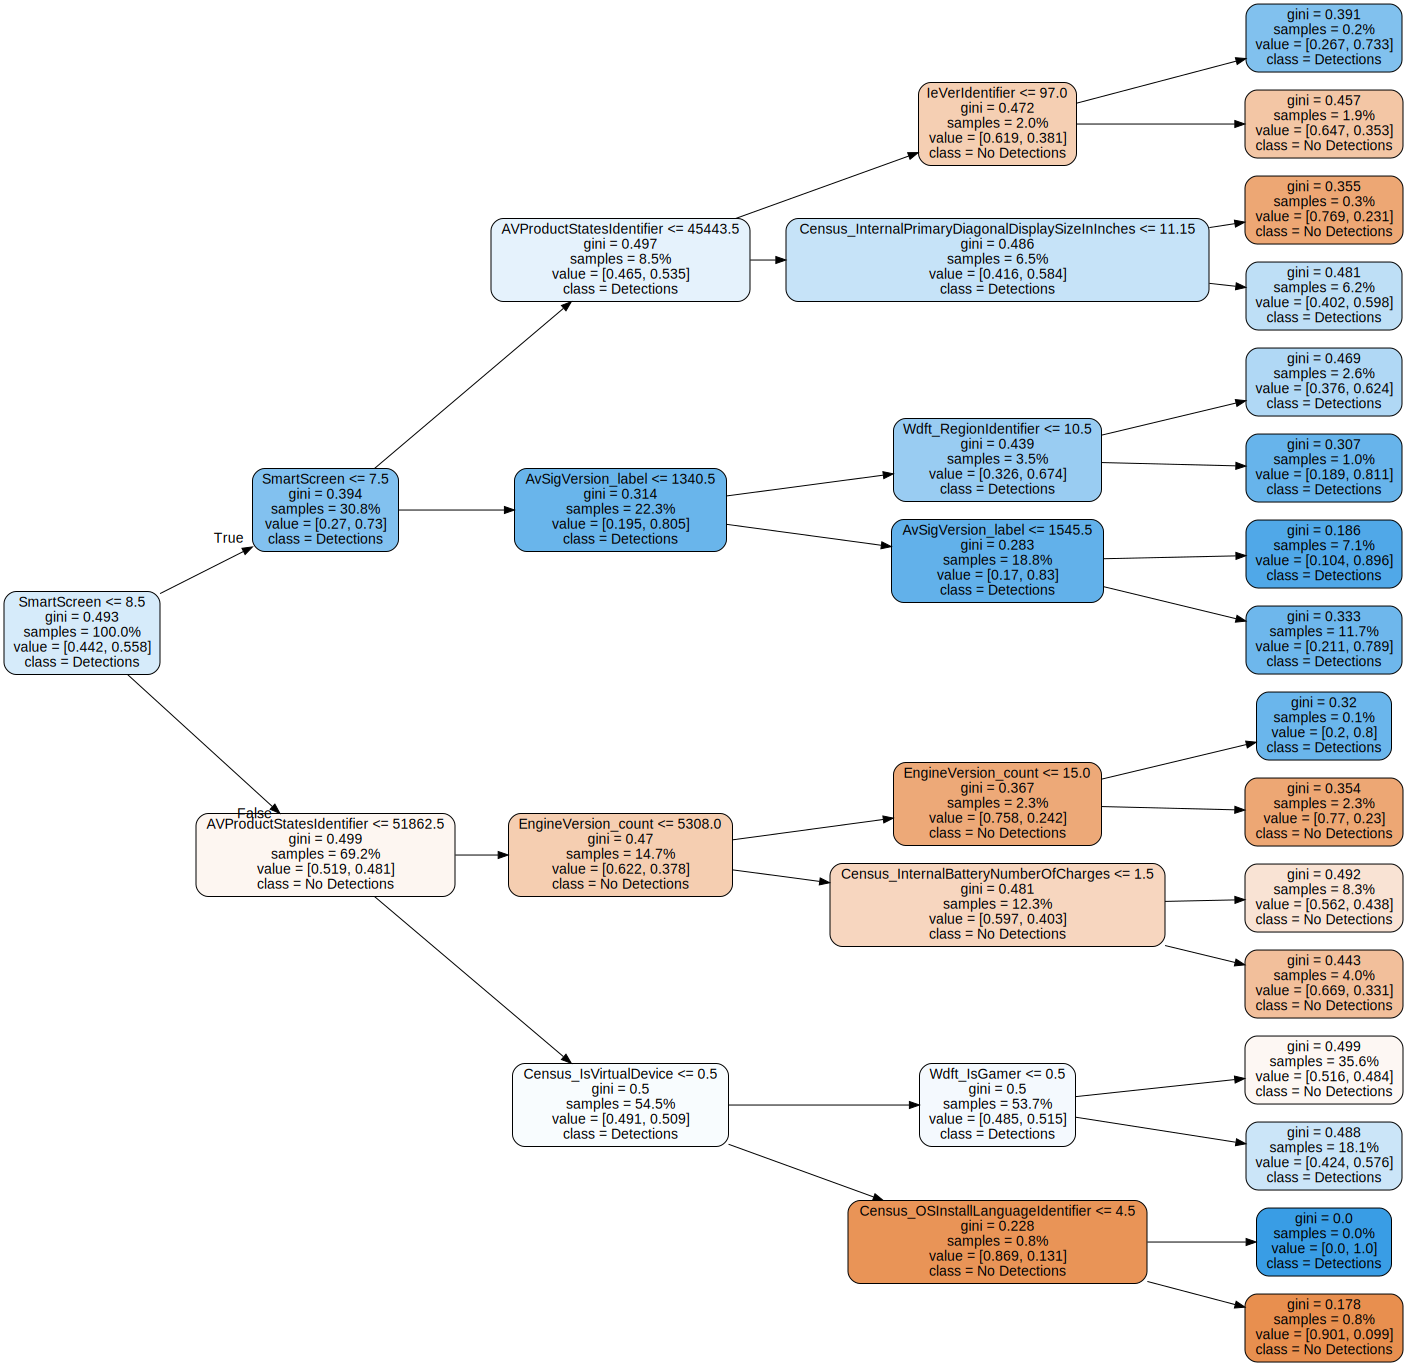

In [3964]:
graph = graphviz.Source(dot_data)
graph

### ML 4.3 Model evaluation

In [3965]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index = y_test.index,  columns = ['DetectionsPred'])

In [3966]:
y_test_pred.head()

,DetectionsPred
16200,1.0
1632,1.0
20462,0.0
17077,0.0
10590,0.0


In [3967]:
y_test_df = pd.DataFrame(y_test)

In [3968]:
y_test.head()

16200    0.0
1632     0.0
20462    0.0
17077    0.0
10590    1.0
Name: HasDetections, dtype: float64

In [3969]:
results_df=y_test_df.join(y_test_pred, how='inner')

In [3970]:
results_df['Success'] = (results_df[TARGET] == results_df['DetectionsPred']).astype(int)

In [3971]:
results_df.head()

,HasDetections,DetectionsPred,Success
16200,0.0,1.0,0
1632,0.0,1.0,0
20462,0.0,0.0,1
17077,0.0,0.0,1
10590,1.0,0.0,0


In [3972]:
results_df['Success'].count()

2487

In [3973]:
results_df['Success'].sum()

1553

In [3974]:
#accuracy
results_df['Success'].mean() # 62% success

0.6244471250502613

###Confusión Matrix

In [3975]:
cnf_matrix = pd.crosstab(results_df[TARGET], results_df['DetectionsPred'])

In [3976]:
cnf_matrix

DetectionsPred,0.0,1.0
HasDetections,,
0.0,759,336
1.0,598,794


In [3977]:
TP = cnf_matrix.iloc[1,1]
TN = cnf_matrix.iloc[0,0]
FP = cnf_matrix.iloc[0,1]
FN = cnf_matrix.iloc[1,0]

In [3978]:
#Accuracy
(TP+TN)/(TP+TN+FP+FN)


0.6244471250502613

In [3979]:
dt.score(X_test, y_test) #accuracy direct

0.6244471250502613

In [3980]:
#F1 score

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

In [3981]:
Precision

0.7026548672566372

In [3982]:
Recall

0.5704022988505747

In [3983]:
f1_score = 2/ (1/Precision+1/Recall)

In [3984]:
f1_score

0.6296590007930215

In [3985]:
metrics.f1_score(y_test, y_test_pred)#f1 Score direct

0.6296590007930214

# AUC & ROC Curve

In [3986]:
metrics.roc_auc_score(results_df[TARGET], results_df['DetectionsPred'])

0.6317764918910407

In [3987]:
#AUC = 0.63 

In [3988]:
fpr, tpr, th = metrics.roc_curve(y_test, y_test_pred)

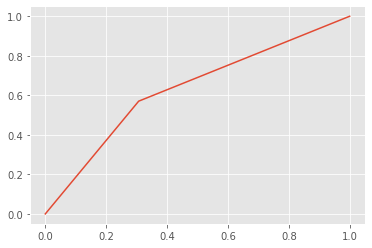

In [3989]:
plt.plot(fpr, tpr)

###Overfitting control

In [3990]:
for i in range(1,20):  
  dt = DecisionTreeClassifier(max_depth = i, random_state=42)
  dt.fit(X_train, y_train)
  train_acc = dt.score(X_train, y_train)
  test_acc = dt.score(X_test, y_test)
  print('Tree depth: {}. Train: {}. Test: {}, difference of {}' .format(i,train_acc,test_acc, np.round(train_acc-test_acc,4) ))

Tree depth: 1. Train: 0.5841126194067371. Test: 0.5991154000804182, difference of -0.015
Tree depth: 2. Train: 0.5937657114127702. Test: 0.5958986731001207, difference of -0.0021
Tree depth: 3. Train: 0.6048265460030166. Test: 0.6047446722959389, difference of 0.0001
Tree depth: 4. Train: 0.6191050779286074. Test: 0.6244471250502613, difference of -0.0053
Tree depth: 5. Train: 0.6267471091000503. Test: 0.619622034579815, difference of 0.0071
Tree depth: 6. Train: 0.6435394670688789. Test: 0.6220345798150382, difference of 0.0215
Tree depth: 7. Train: 0.6554047259929613. Test: 0.6188178528347407, difference of 0.0366
Tree depth: 8. Train: 0.6777275012569131. Test: 0.6127864897466827, difference of 0.0649
Tree depth: 9. Train: 0.6951231774761186. Test: 0.6103739445114595, difference of 0.0847
Tree depth: 10. Train: 0.7210658622423328. Test: 0.5999195818254925, difference of 0.1211
Tree depth: 11. Train: 0.7462041226747109. Test: 0.5922798552472859, difference of 0.1539
Tree depth: 12. Tr

In [3991]:
#3<=depth<=6 ok

### Other algorithms

In [3992]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3993]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 5, random_state=42)

In [3994]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [3995]:
rf.score(X_train, y_train)

0.6411261940673706

In [3996]:
tree_list = rf.estimators_

In [3997]:
dot_data_rf2 = export_graphviz(
    
    decision_tree = tree_list[2],
    out_file=None,
    #max_depth=None,
    feature_names=X_test.columns,
    class_names=['No Detections', 'Detections'],
    #label="all",
    filled=True,
    #leaves_parallel=False,
    impurity=True,
    #node_ids=False,
    proportion=True,
    rotate=True,
    rounded=True,
    #special_characters=False,
    precision=3,
    #fontname="helvetica"

)

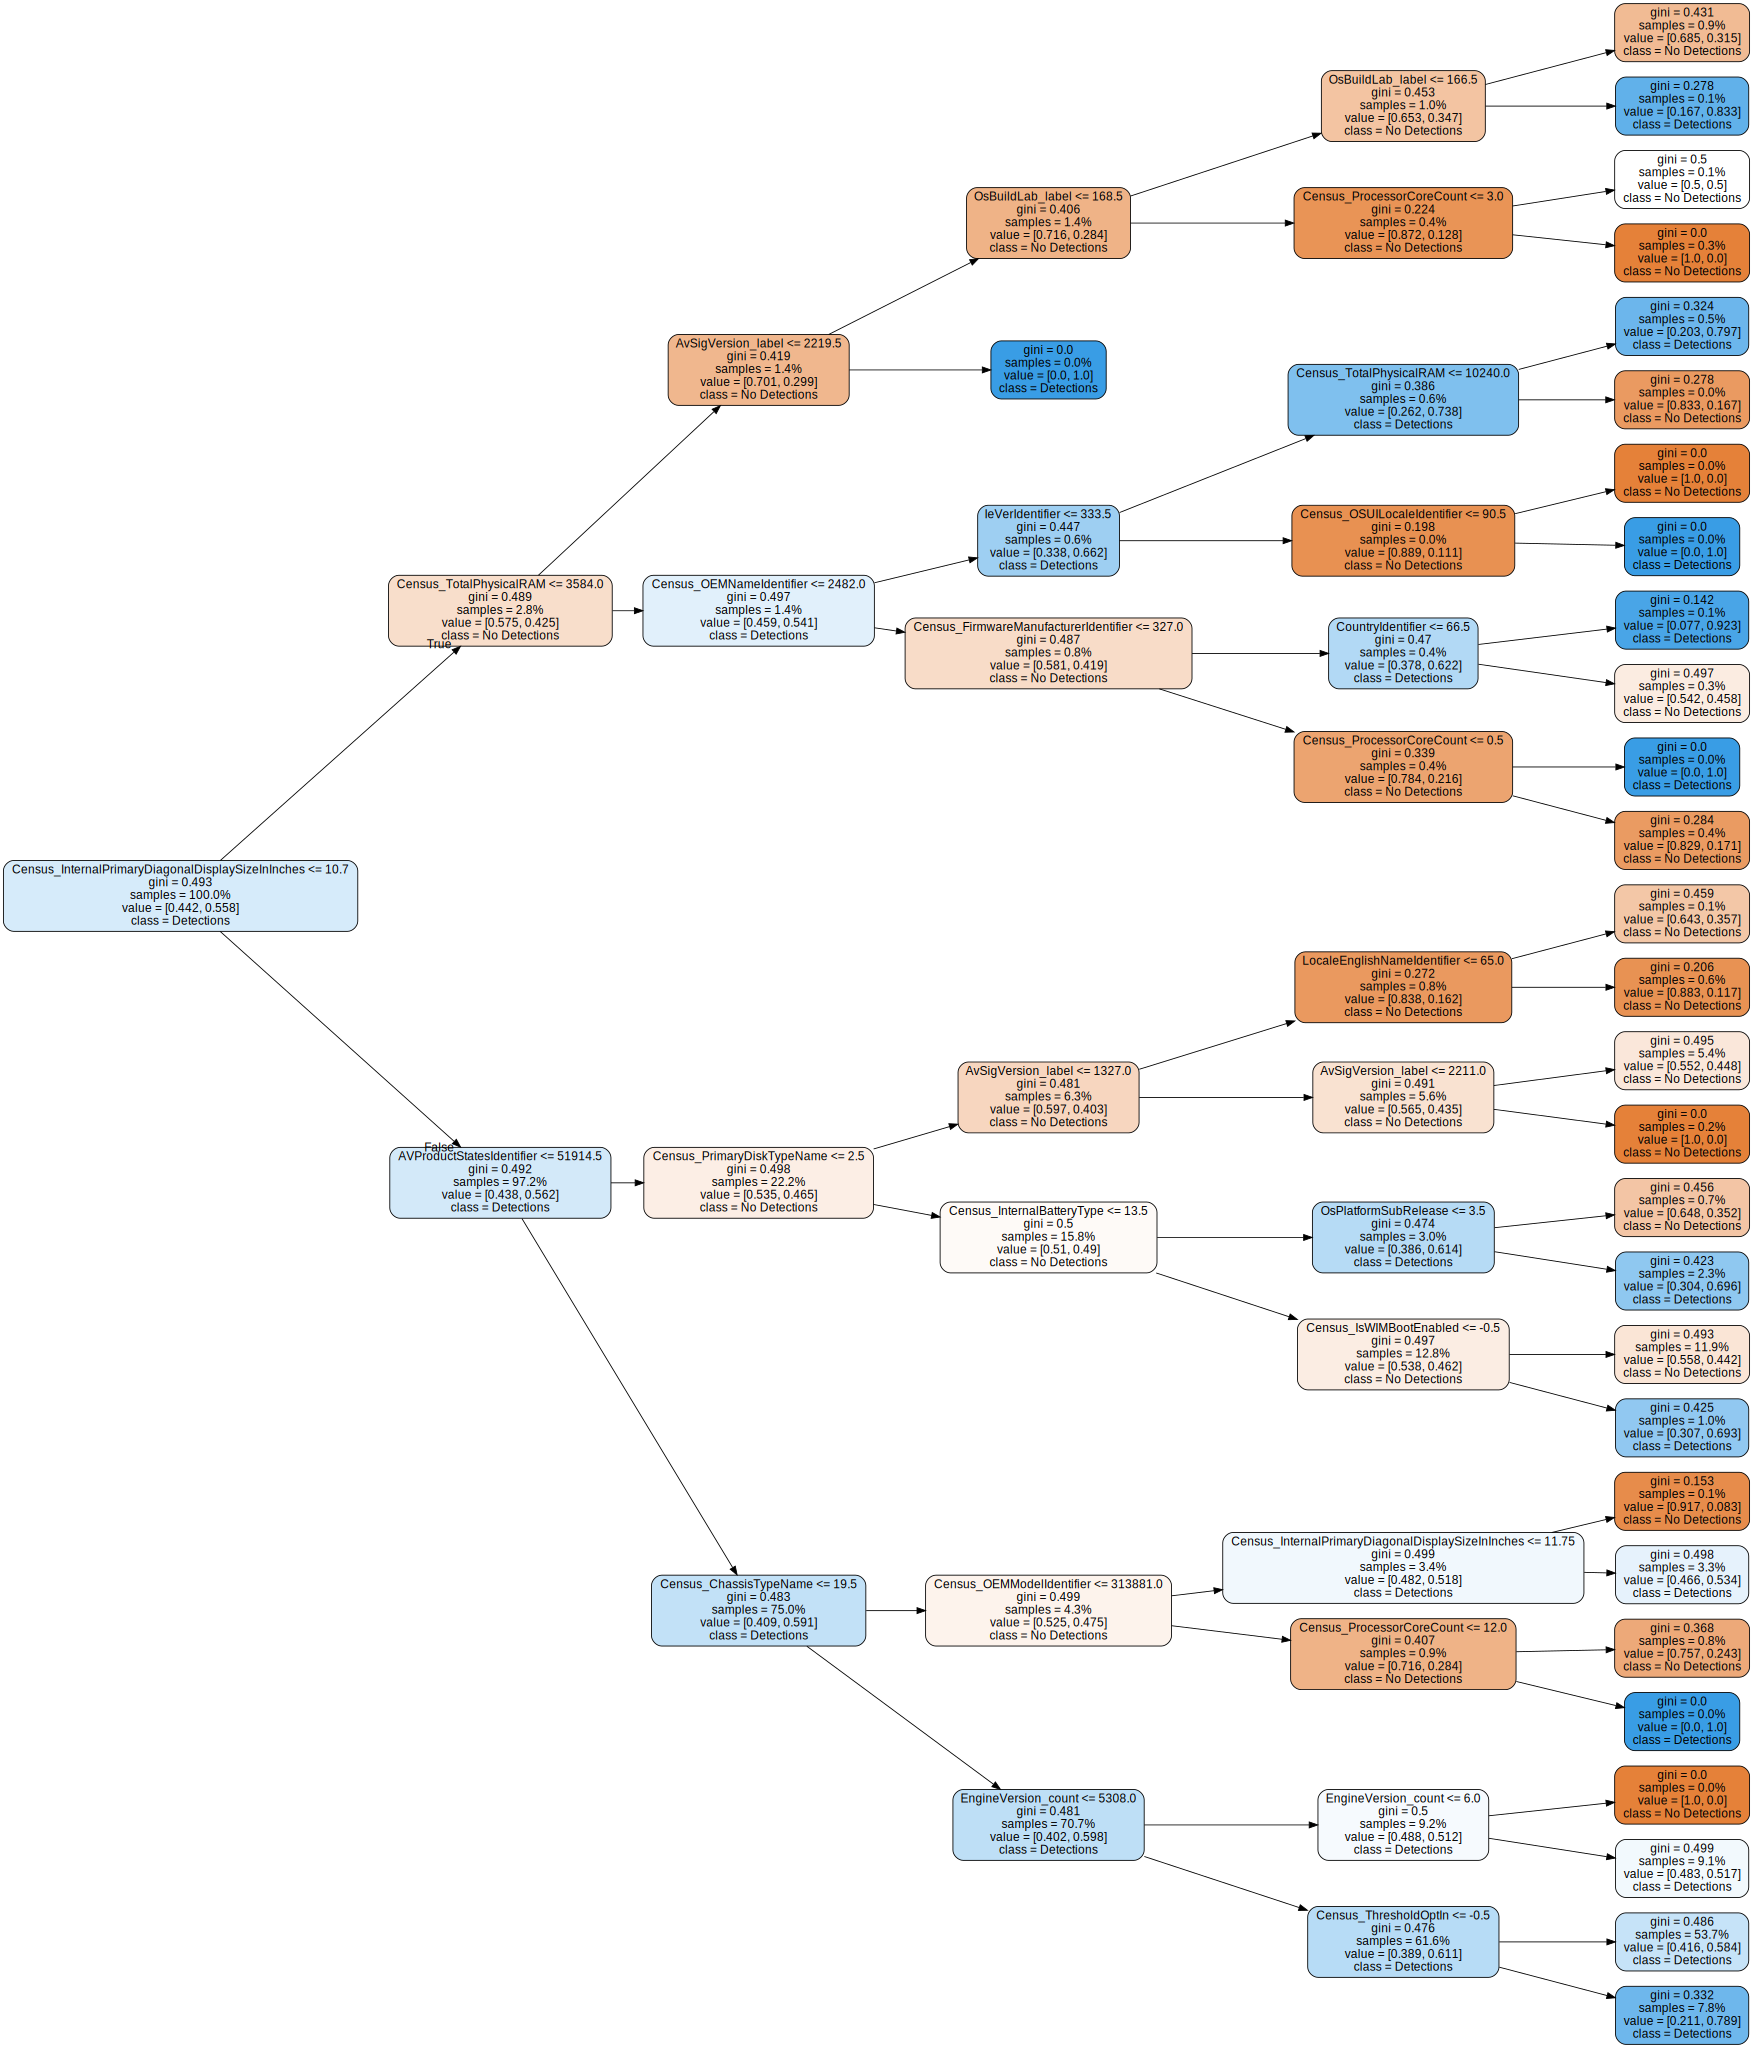

In [3998]:
graphviz.Source(dot_data_rf2)

In [3999]:
pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = False).head(20)

SmartScreen                                          0.289618
Census_ThresholdOptIn                                0.064744
AVProductStatesIdentifier                            0.063061
Census_IsWIMBootEnabled                              0.047247
AVProductsInstalled                                  0.039677
Processor                                            0.036225
Census_IsVirtualDevice                               0.033368
AvSigVersion_label                                   0.027588
Census_SystemVolumeTotalCapacity                     0.024488
OsBuildLab_label                                     0.020991
EngineVersion_count                                  0.018900
Census_OSVersion_count                               0.018093
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.017789
Census_OEMNameIdentifier                             0.016792
Census_InternalBatteryType                           0.016117
Census_TotalPhysicalRAM                              0.015127
Census_O

In [4000]:
grad_boost = GradientBoostingClassifier(n_estimators= 20, max_depth =2, random_state = 42)

In [4001]:
grad_boost.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=20, random_state=42)

In [4002]:
grad_boost.score(X_train, y_train)

0.6225238813474108

In [4003]:
df_list_objects = df.select_dtypes(include=[object])

In [4004]:
df_list_objects.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,24161,24162,24163,24164,24165,24166,24167,24168,24169,24170,24171,24172,24173,24174,24175,24176,24177,24178,24179,24180,24181,24182,24183,24184,24185,24186,24187,24188,24189,24190,24191,24192,24193,24194,24195,24196,24197,24198,24199,24200


In [4005]:
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,SkuEdition,IsProtected,SMode,IeVerIdentifier,SmartScreen,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSArchitecture,Census_OSBuildNumber,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,EngineVersion_count,AppVersion_count,AvSigVersion_label,OsBuildLab_label,Census_MDC2FormFactor_label,Census_OSVersion_count,Census_OSBranch_label,Census_OSEdition_label
0,1,7.0,0,53447.0,1.0,1.0,1,8,85219.0,-1.0,205.0,172,4,1,5,17134,256,9,7,1.0,0.0,137.0,10.0,1443.0,275891.0,4.0,2273.0,4,953869.0,3,952838.0,0.0,8192.0,20,23.0,1080.0,7,14,4.294967e+09,2,17134.0,13.0,9,27.0,120.0,6,0.0,4,5,-1.0,7,-1.0,355.0,19951.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,9943,14195,1359,168,2,2520,5,11
1,1,7.0,0,53447.0,1.0,1.0,1,129,54198.0,-1.0,126.0,124,4,1,5,17134,256,9,7,1.0,0.0,137.0,10.0,2102.0,248850.0,4.0,2660.0,4,476940.0,3,457600.0,0.0,8192.0,24,13.2,720.0,8,13,0.000000e+00,2,17134.0,13.0,9,18.0,72.0,6,0.0,4,5,-1.0,7,0.0,486.0,48753.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,9943,14195,1378,168,7,2520,5,11
2,1,7.0,0,46067.0,2.0,1.0,1,80,7182.0,27.0,101.0,107,4,1,5,17134,768,9,8,1.0,0.0,137.0,10.0,1443.0,256588.0,4.0,2373.0,4,953869.0,3,939693.0,0.0,4096.0,22,15.5,768.0,8,14,0.000000e+00,2,17134.0,14.0,9,6.0,28.0,6,0.0,4,5,-1.0,7,-1.0,355.0,20106.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,9943,14195,1583,168,7,2520,5,1
3,1,7.0,0,53447.0,1.0,1.0,1,107,57144.0,27.0,138.0,134,4,1,5,17134,768,9,8,1.0,0.0,137.0,9.0,2689.0,111353.0,4.0,2412.0,4,122104.0,2,104419.0,0.0,4096.0,20,21.7,1080.0,7,14,4.294967e+09,2,17134.0,14.0,4,20.0,83.0,6,0.0,4,5,-1.0,7,-1.0,807.0,9834.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9943,14195,1451,168,0,2520,5,1
4,1,7.0,0,53447.0,1.0,1.0,1,220,40292.0,18.0,237.0,72,4,1,5,17134,768,9,8,1.0,0.0,137.0,10.0,2668.0,210020.0,4.0,2321.0,4,476940.0,3,450051.0,0.0,4096.0,20,21.5,1080.0,7,14,4.294967e+09,2,17134.0,12.0,9,8.0,31.0,6,0.0,4,6,0.0,7,0.0,628.0,49991.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,1.0,9943,14195,1333,168,0,2520,5,4
